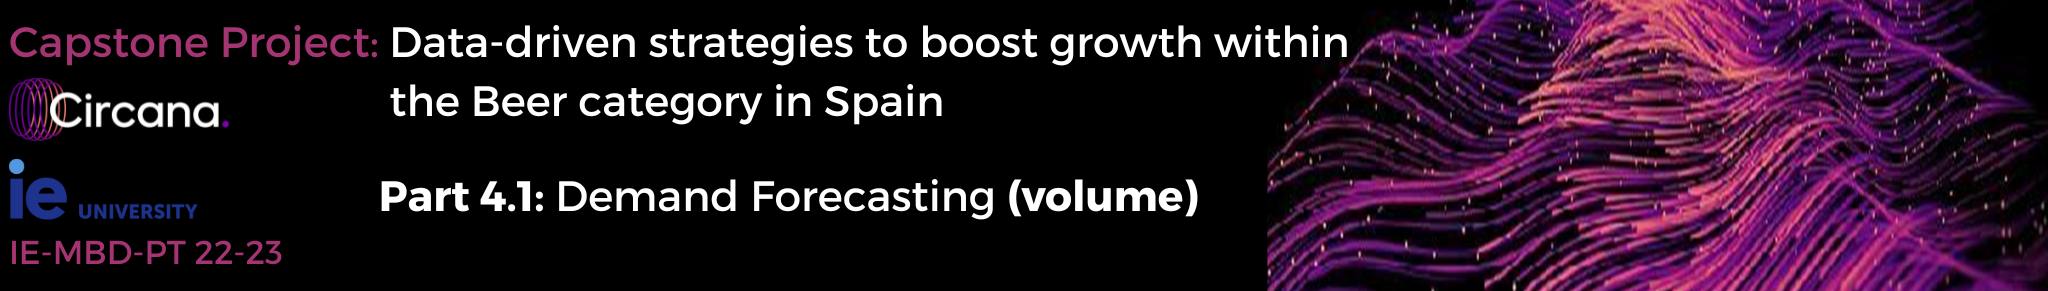

In [1]:
from IPython.display import Image
Image(filename='images/header-part4.1.png')

**We will structure the forecasting exercise into 2 different notebooks. The part 1 (the present notebook), will be oriented to the forecasting of sales in Volume while, the second one, will reapply the analysis and the code but this time for the sales in Value.**

**The reason is that predicting sales in Value can be a more opaque exercise as it is not only a function of the volume but also of the price. So, our volume can decrease but our sales in value can increase if the price increases more than the volume decreases. This can be bad for the company if the cost of the product increases more than the price and the volume decreases.**

So, summarizing, this notebook will only focus on the forecasting of the volume. The second notebook will focus on the forecasting of the value.

## <span style="color: purple">**Table of contents**</span> <a class="anchor"></a>
- [<span style="color: purple">0. Preparing the environment</span>](#section_0)
- [<span style="color: purple">1. Exploratory Data Analysis for Demand Forecasting</span>](#section_1)
  - [<span style="color: purple">1.1. Preparing the data</span>](#section_1_1)
  - [<span style="color: purple">1.2. Analyzing our data evolution through time</span>](#section_1_2)
- [<span style="color: purple">2. Modeling for Segment Demand Forecasting</span>](#section_2)
  - [<span style="color: purple">2.1. Simple Autoarima model</span>](#section_2_1)
  - [<span style="color: purple">2.2. Autoarima model with hyperparameter tuning</span>](#section_2_2)
  - [<span style="color: purple">2.3. Simple LightGBM</span>](#section_2_3)
  - [<span style="color: purple">2.4. Complete Light GBM</span>](#section_2_4)
- [<span style="color: purple">3. Modeling for Manufacturer Demand Forecasting</span>](#section_3)
  - [<span style="color: purple">3.1. Simple Autoarima model</span>](#section_3_1)
  - [<span style="color: purple">3.2. Autoarima model with hyperparameter tuning</span>](#section_3_2)
  - [<span style="color: purple">3.3. Simple LightGBM</span>](#section_3_3)
  - [<span style="color: purple">3.4. Complete Light GBM</span>](#section_3_4)
- [<span style="color: purple">4. Modeling for Stores Demand Forecasting</span>](#section_4)
  - [<span style="color: purple">4.1. Light GBM</span>](#section_4_1)
  - [<span style="color: purple">4.2. Light GBM with Finetuning</span>](#section_4_2)
- [<span style="color: purple">5. Forecasting applying the best models</span>](#section_5)
  - [<span style="color: purple">5.1. Short Term Forecasting for segments</span>](#section_5_1)
  - [<span style="color: purple">5.2. Long Term Forecasting for segments</span>](#section_5_2)
  - [<span style="color: purple">5.3. Short Term Forecasting for manufacturers</span>](#section_5_3)
  - [<span style="color: purple">5.4. Long Term Forecasting for manufacturers</span>](#section_5_4)
- [<span style="color: purple">6. Conclusions on the work performed</span>](#section_6)
- [<span style="color: purple">7. Some "big" numbers on the forecasting</span>](#section_7)
  - [<span style="color: purple">7.1. The 2023-2024 numbers for segments</span>](#section_7_1)
  - [<span style="color: purple">7.2. The 2023-2024 numbers for manufacturers</span>](#section_7_2)
  - [<span style="color: purple">7.3. The 2023-2024 numbers for beer</span>](#section_7_3)
- [<span style="color: purple">8. A final combined approach</span>](#section_8)
  

  


## <span style="color: purple">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer


#Autoarima
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Autoarima with hyperparameter tuning
from itertools import product

#LightGBM
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings("ignore")

In [2]:
#We import the data, based on the previously created dataset
original_data = pd.read_csv('datasets/circana_data.csv')


# <span style="color: purple">**1. Exploratory Data Analysis for Demand Forecasting**</span> <a class="anchor" id="section_1"></a>


## <span style="color: purple">1.1. Preparing the data</span> <a class="anchor" id="section_1_1"></a>

As the objective that the client want us to achieve is to forecast segment demand and manufacturer demand, we will start by preparing and analyzing the data to accomplish that objective.

In [3]:
#Creating a new DataFrame with the columns for our analysis
ts_simple_data = original_data[['Week Code', 'Sales in volume (Lt)', 'SEGMENT','MANUFACTURER','Month', 'Year', 'Season', 'Quarter']]

In [4]:
#We will sort the data by the Week Code
ts_simple_data = ts_simple_data.sort_values(by=['Week Code'])

In [5]:
#As we have many rows with the same combination, we will group the data by the columns we want to analyze
ts_simple_data= ts_simple_data.groupby(["Week Code", "SEGMENT", "MANUFACTURER", "Month", "Year", "Season", "Quarter"]).sum().reset_index()

In [64]:
ts_simple_data.head()

Week Code   SEGMENT         MANUFACTURER  Month  Year  Season  Quarter  \
0          1  ARTISANS       MANUFACTURER 5      1  2021  Winter        1   
1          1  ARTISANS  OTHER MANUFACTURERS      1  2021  Winter        1   
2          1     BLACK       MANUFACTURER 1      1  2021  Winter        1   
3          1     BLACK       MANUFACTURER 2      1  2021  Winter        1   
4          1     BLACK       MANUFACTURER 3      1  2021  Winter        1   

   Sales in volume (Lt)  
0                   171  
1                   952  
2                   699  
3                  1569  
4                   794

In [65]:
ts_simple_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             6702 non-null   int64 
 1   SEGMENT               6702 non-null   object
 2   MANUFACTURER          6702 non-null   object
 3   Month                 6702 non-null   int64 
 4   Year                  6702 non-null   int64 
 5   Season                6702 non-null   object
 6   Quarter               6702 non-null   int64 
 7   Sales in volume (Lt)  6702 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 419.0+ KB


## <span style="color: purple">1.2. Analyzing our data evolution through time</span> <a class="anchor" id="section_1_2"></a>

Despite we have already performed a detailed EDA at the beginning of our project, at this stage we will start our time series analysis but plotting some visualizations closely related with the temporal evolution of sales.

First, we will plot how **sales of the category (beer)** have been evolving through the period.

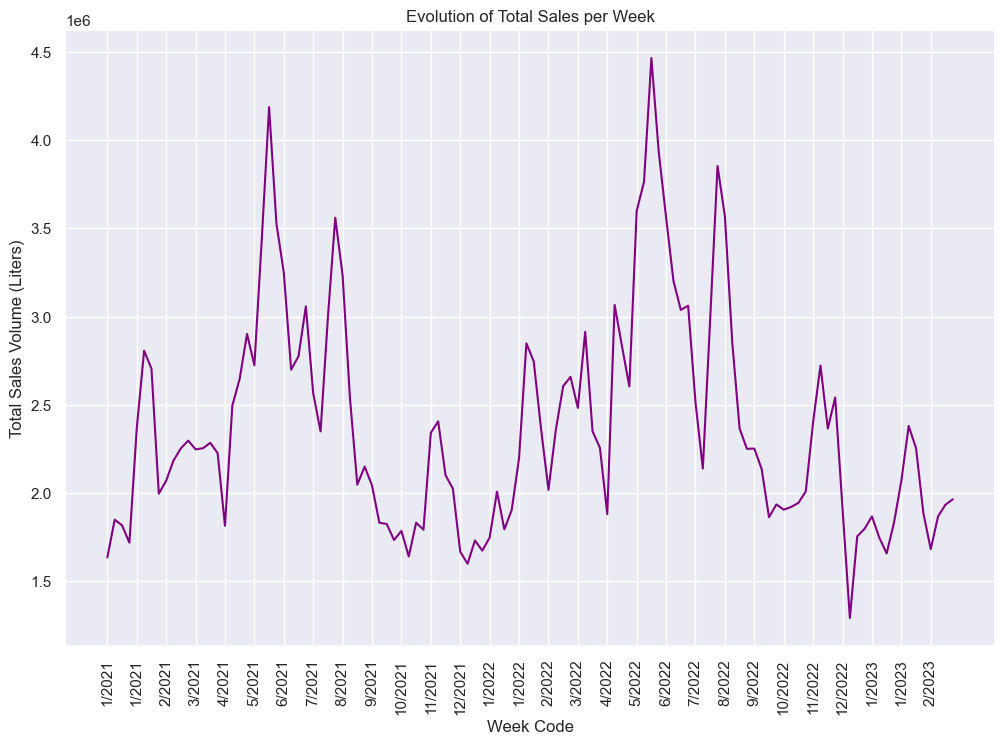

In [66]:
#Group df by week code
weekly_sales = ts_simple_data.groupby('Week Code')['Sales in volume (Lt)'].sum()

#Get month and year for each week code
months = ts_simple_data.groupby('Week Code')['Month'].first()
years = ts_simple_data.groupby('Week Code')['Year'].first()

#Plotting the graph
plt.figure(figsize=(12, 8))
plt.plot(weekly_sales.index, weekly_sales.values, color= 'purple')
plt.xlabel('Week Code')
plt.ylabel('Total Sales Volume (Liters)')
plt.title('Evolution of Total Sales per Week')

labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')

plt.show()


As we can see the beer sales seem (in general terms) quite stable (not increasing or decreasing market) but with a high seasonality factor, with high peaks and drops

Now, let's analyze the weekly sales evolution but, this time, depending on **segment**

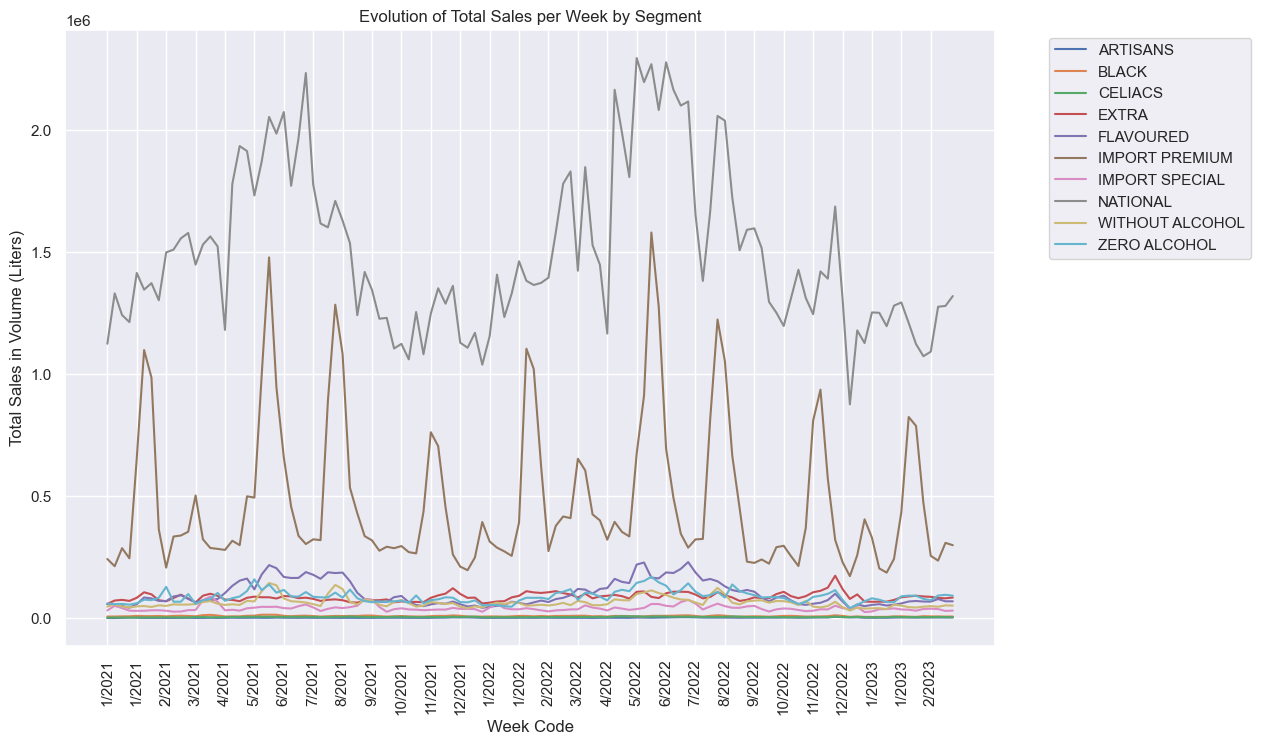

In [67]:

#Group df by week code and segment
segment_sales = ts_simple_data.groupby(['Week Code', 'SEGMENT'])['Sales in volume (Lt)'].sum()

#Get the unique segments
segments = ts_simple_data['SEGMENT'].unique()


plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each segment
for segment in segments:
    segment_data = segment_sales.loc[:, segment]
    plt.plot(segment_data.index, segment_data.values, label=segment)

plt.xlabel('Week Code')
plt.ylabel('Total Sales in Volume (Liters)')
plt.title('Evolution of Total Sales per Week by Segment')

#We add the months labels previously created
labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')


#Adjust the legend position to be able to see the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Quite interesting graph. As we can see, the seasonality factor is present in all of the segments but **national** segment is much more stable than **import premium** (the second most popular segment) which has much more fluctuations in shorter periods.

The other segments have significantly lower sales, so we will **normalize the data** to be able to compare all the segments easier.

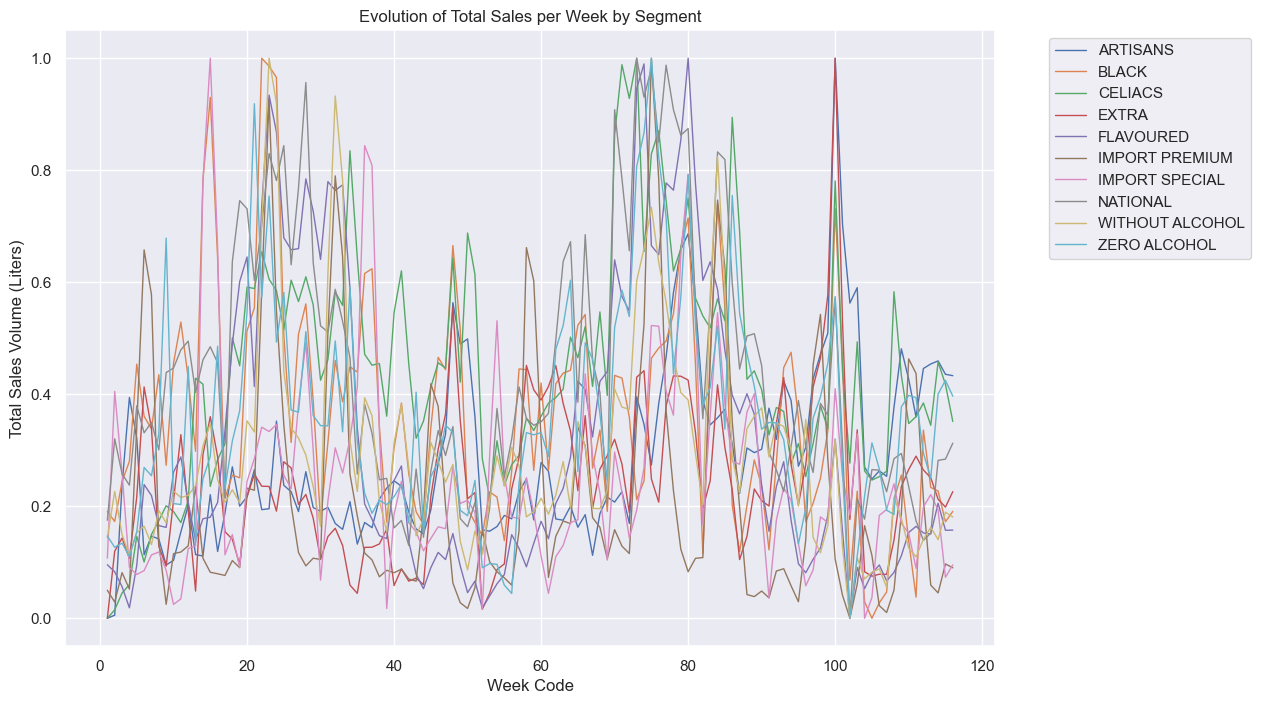

In [68]:

#We start by normalizing the sales volume between 0 and 1 for each segment
normalized_sales = segment_sales.groupby('SEGMENT').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each segment
for segment in segments:
    segment_data = normalized_sales.loc[:, segment]
    plt.plot(segment_data.index, segment_data.values, label=segment, linewidth=1)

plt.xlabel('Week Code')
plt.ylabel('Total Sales Volume (Liters)')
plt.title('Evolution of Total Sales per Week by Segment')


#Adjust the legend position for a better visualization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

It seems as if not all the segments have the same periods of fluctuations. But, as we cannot visualize that aspect properly, let's print each of them separately

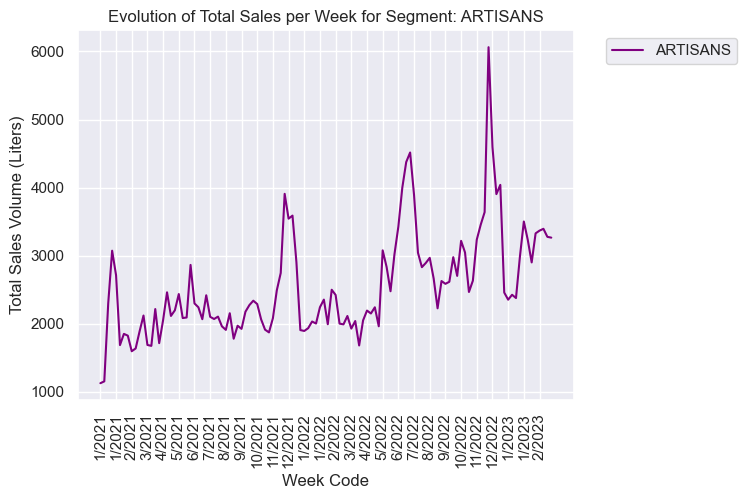

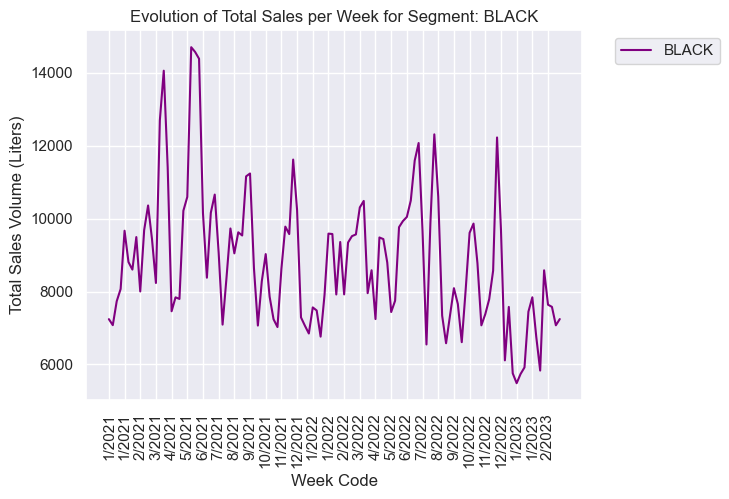

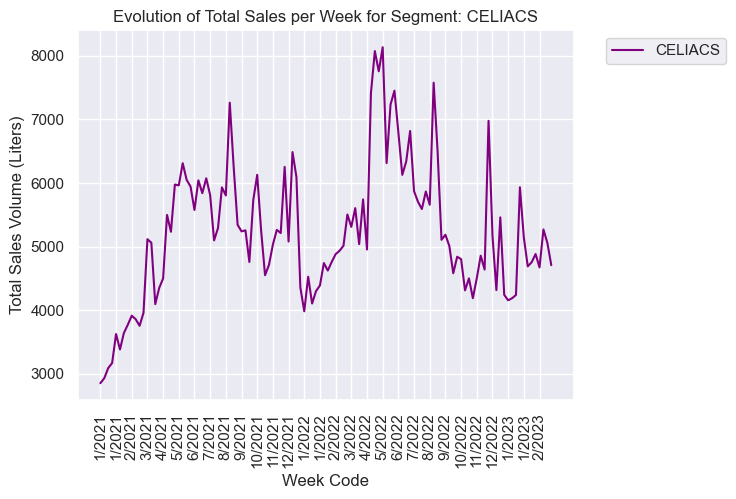

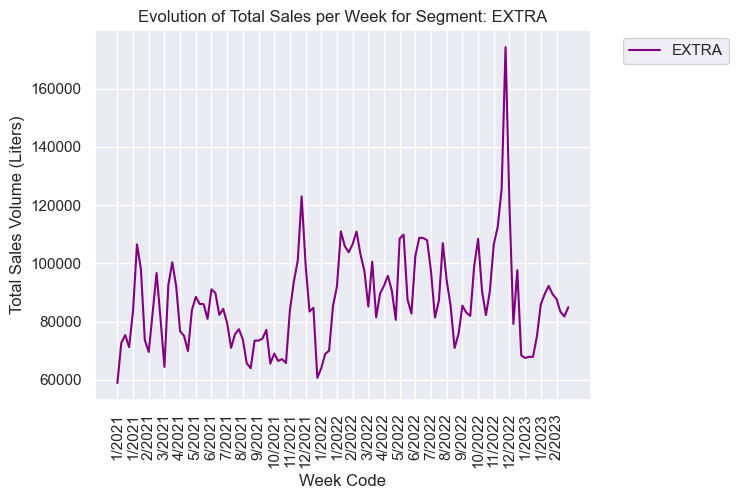

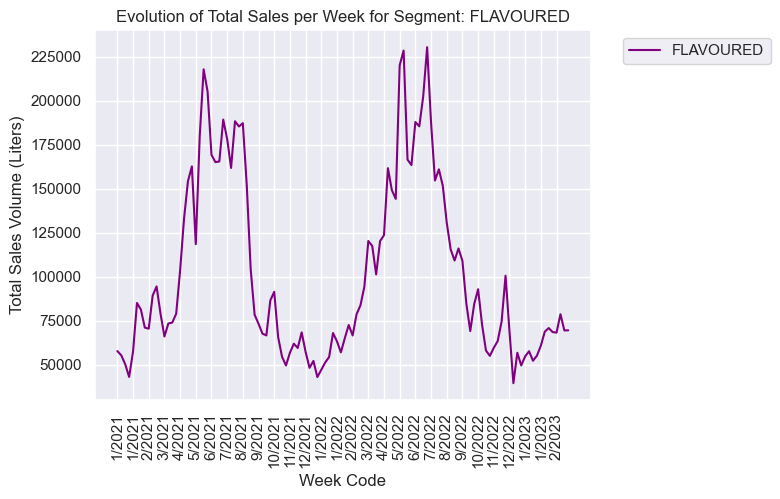

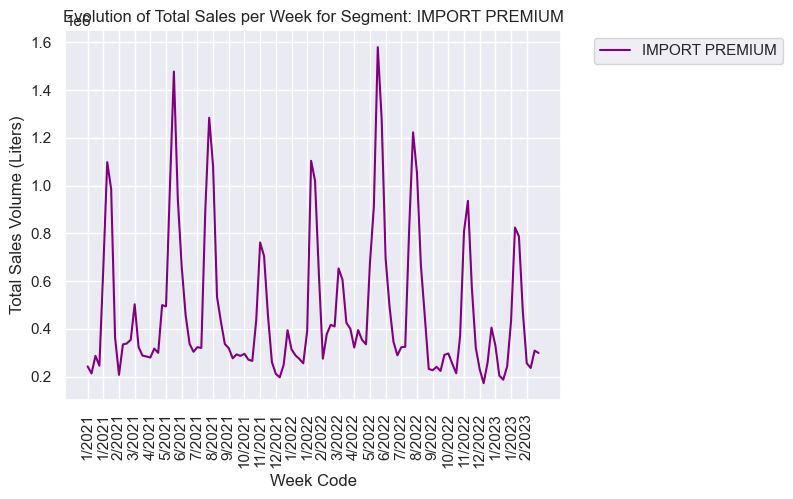

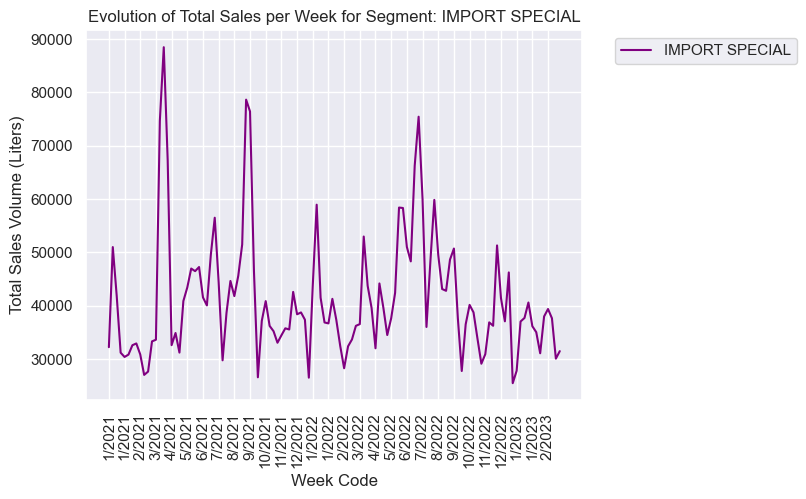

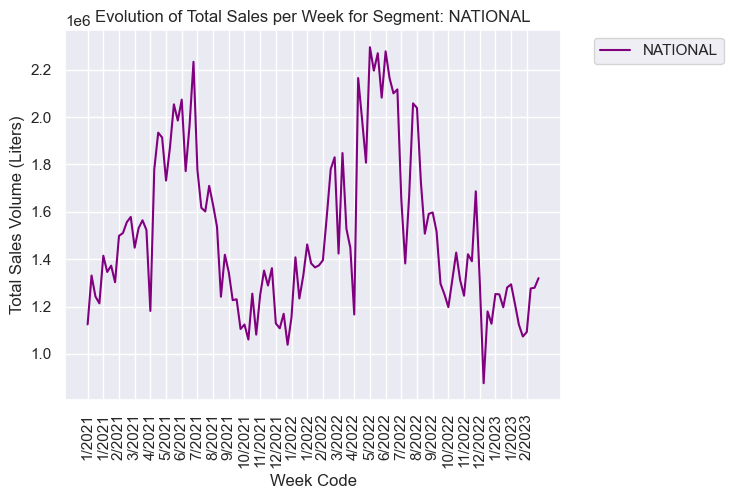

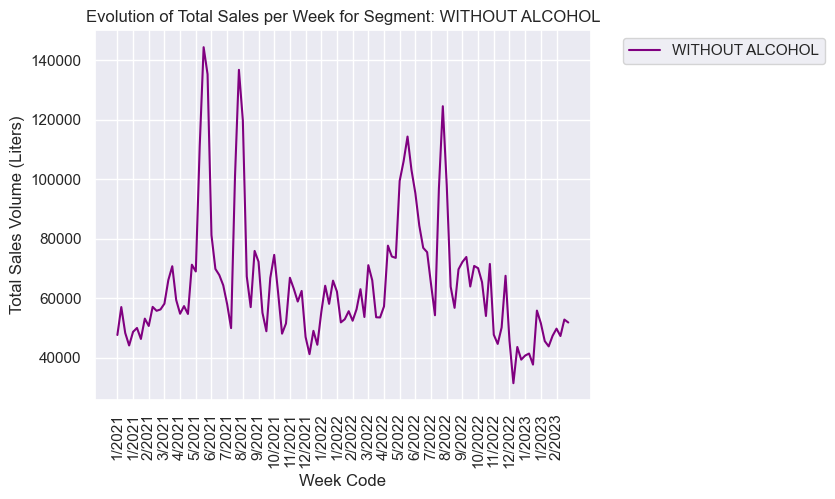

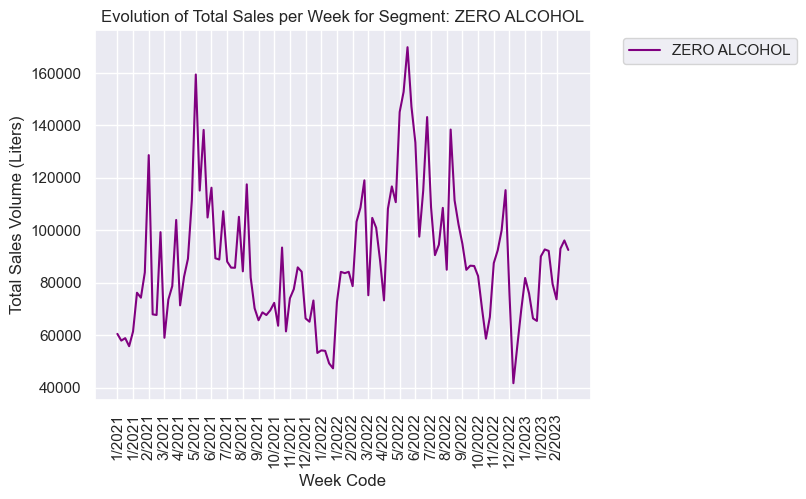

In [69]:
#Iterate over each segment and create a separate plot
for segment in segments:
    #First, we create a new figure and axes for each segment
    fig, ax = plt.subplots()
    
    #We get the specific data of the segment
    segment_data = segment_sales.loc[:, segment]
    
    #Plot the data
    ax.plot(segment_data.index, segment_data.values, label=segment, color='purple')
    ax.set_xlabel('Week Code')
    ax.set_ylabel('Total Sales Volume (Liters)')
    ax.set_title(f'Evolution of Total Sales per Week for Segment: {segment}')
    

    #Display previosuly created labels
    display_labels = labels[::4]
    display_indices = segment_data.index[::4]
    ax.set_xticks(display_indices)
    ax.set_xticklabels(display_labels, rotation='vertical')
    
    #Adjust the legend position for better visualization
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

From the previous graphs, we can extract some conclusions:

- **National**: Overall, is worthy mention that it has have a huge drop in december of 2022. The seasonality here is really clear, with highest in spring-summer seasons. The fluctuation between weeks is not as prominent as in other segments
- **Import Premium**: it is one of the most interesting segments. It has highest peaks also in springs-summer periods but the main seasonality seem to happen in certain weeks of each months, so, each month, we can find a week with an important increase on sales and then a drop for the rest of the month
- **Import special**: Simmilar trend than import premium, but no as drastic.
- **Zero alcohol** and **without alcohol**: Both of them present a behaviour similar of the one that National is presenting but with a highest volatilty among weeks. Also, we may spot that general trend for without alcohol sales is a slight decrease in sales while a slight increase on zero alcohol
- **Flavoured**: it presents quite an stable trend, sales start growing at january and the, reach their peak in summer seasons to start a decrease again, until reaching bottom in december and then, starting again.
- **Extra**: the seasonality level seem in between weeks of the month, not in seasons. It seems that the segment is growing its presence in the market.
- **Celiac**: More stable trend but with an on-going upwards trend.
- **Black**: Overall, we can state that black beer seems to be tending to lose market presence.
- **Artisans**: probably, this is the segment which seems to be experiencing the highest increase in sales (percentually)

Now, let's analyze the weekly sales evolution but, this time, depending on **manufacturer**

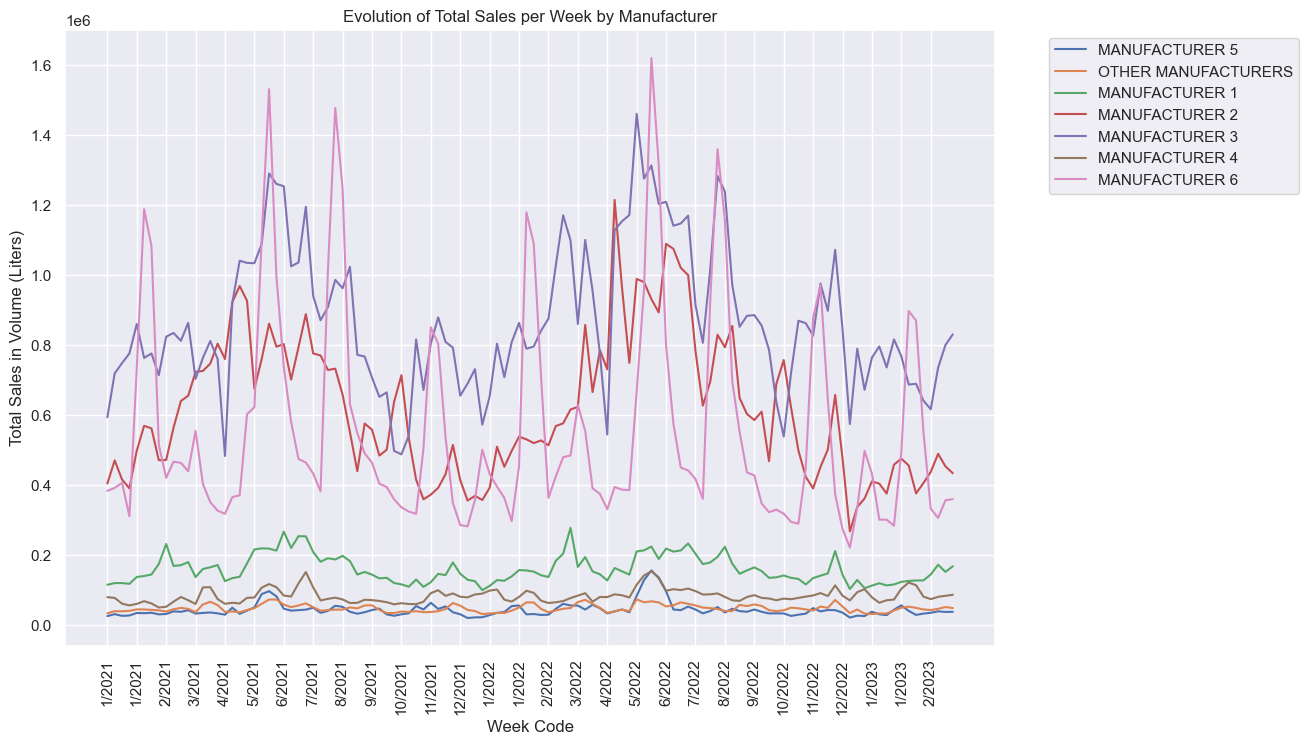

In [70]:

#Group df by week code and manufacturer
manufacturer_sales = ts_simple_data.groupby(['Week Code', 'MANUFACTURER'])['Sales in volume (Lt)'].sum()

#Get the unique manufacturer
manufacturers = ts_simple_data['MANUFACTURER'].unique()


plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each manufacturer
for manufacturer in manufacturers:
    manufacturer_data = manufacturer_sales.loc[:, manufacturer]
    plt.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer)

plt.xlabel('Week Code')
plt.ylabel('Total Sales in Volume (Liters)')
plt.title('Evolution of Total Sales per Week by Manufacturer')

#We add the months labels previously created
labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')


#Adjust the legend position to be able to see the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Previously to normalize variables, we can probably spot that manufacturer 6 has quite a simmilar trend than import premium segment.

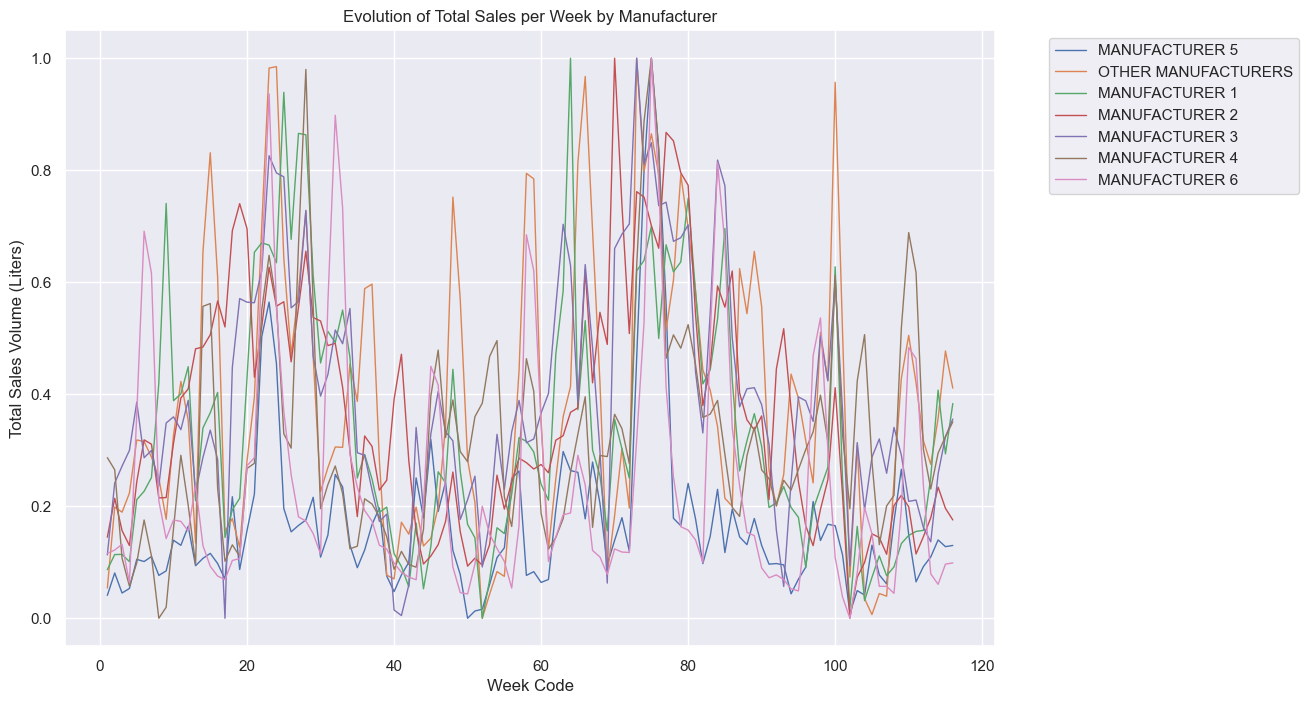

In [71]:

#We start by normalizing the sales volume between 0 and 1 for each manufacturer
normalized_manufacturer = manufacturer_sales.groupby('MANUFACTURER').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each manufacturer
for manufacturer in manufacturers:
    manufacturer_data = normalized_manufacturer.loc[:, manufacturer]
    plt.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer, linewidth=1)

plt.xlabel('Week Code')
plt.ylabel('Total Sales Volume (Liters)')
plt.title('Evolution of Total Sales per Week by Manufacturer')


#Adjust the legend position for a better visualization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

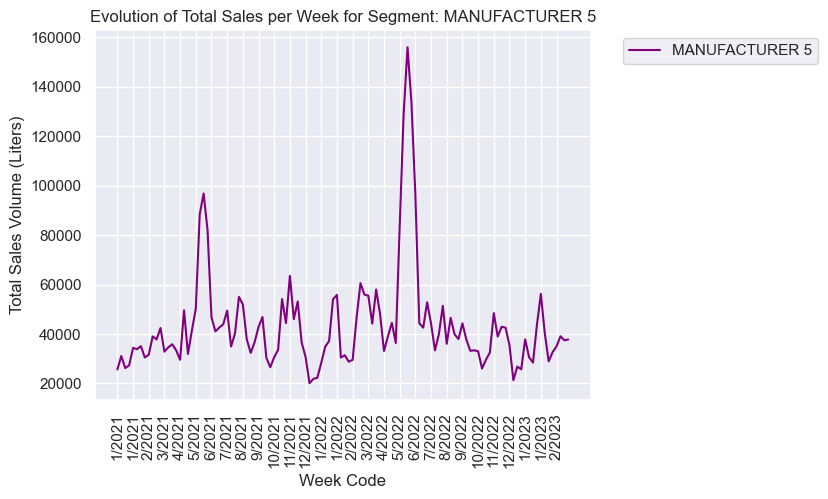

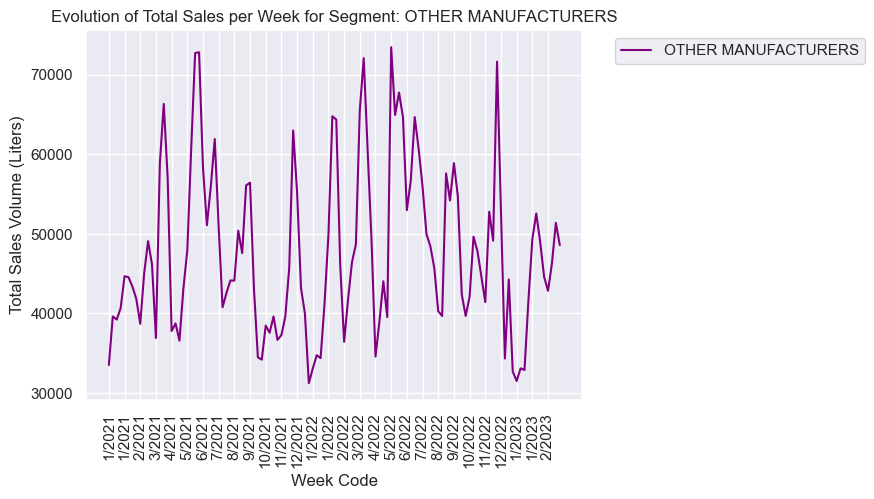

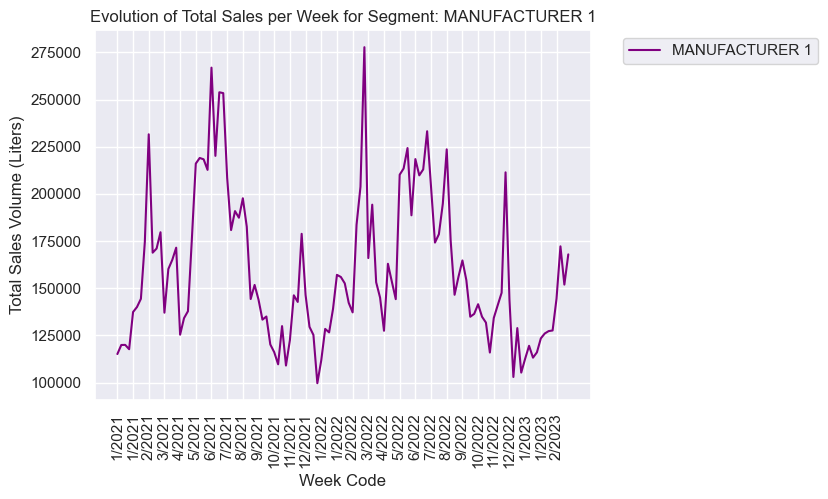

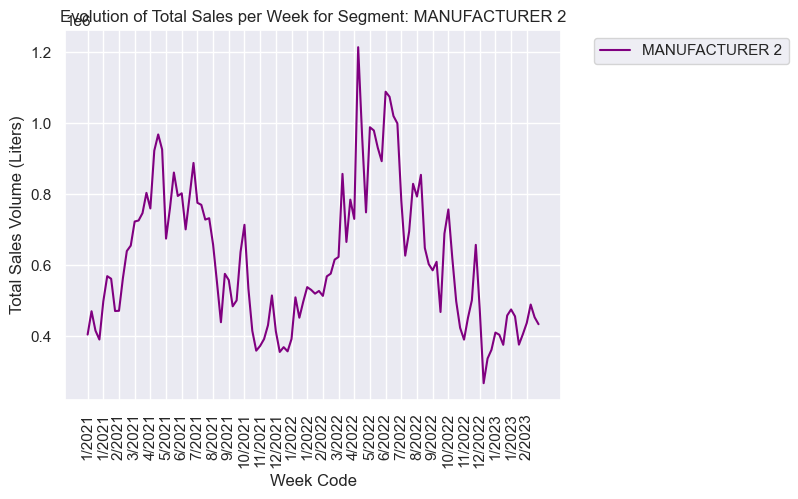

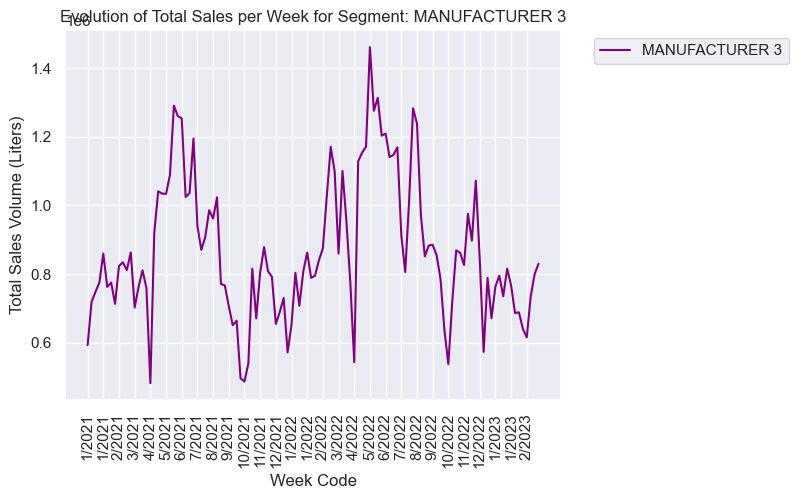

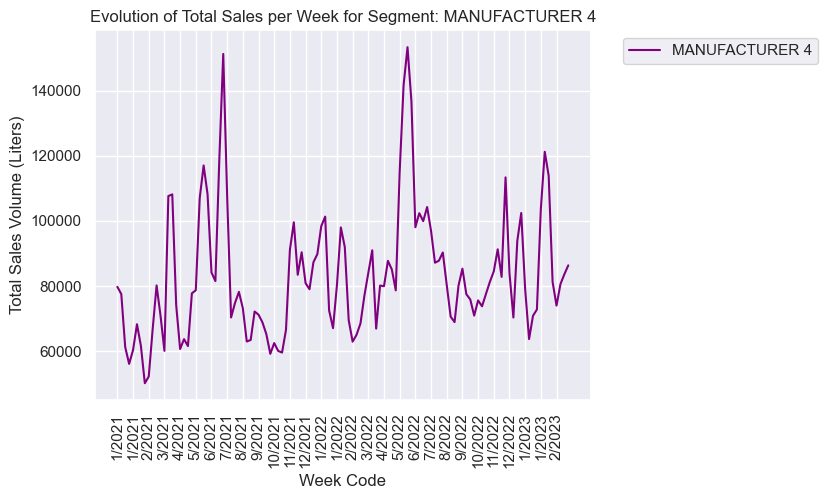

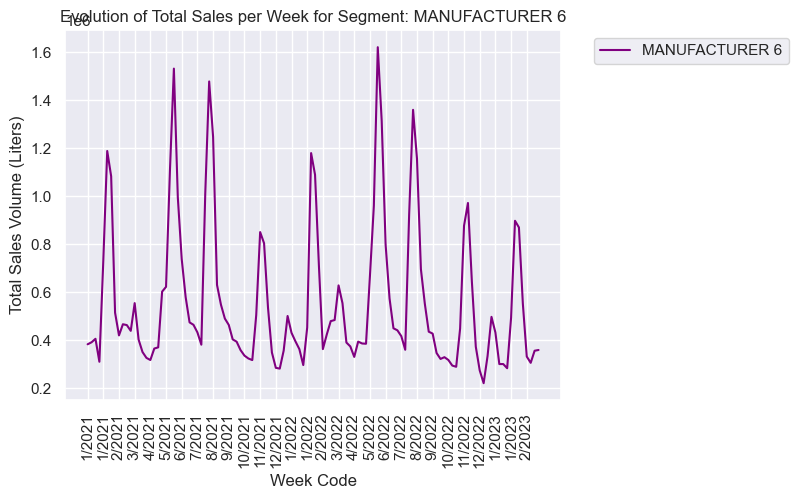

In [72]:
#Iterate over each segment and create a separate plot
for manufacturer in manufacturers:
    #First, we create a new figure and axes for each segment
    fig, ax = plt.subplots()
    
    #We get the specific data of the segment
    manufacturer_data = manufacturer_sales.loc[:, manufacturer]
    
    #Plot the data
    ax.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer, color='purple')
    ax.set_xlabel('Week Code')
    ax.set_ylabel('Total Sales Volume (Liters)')
    ax.set_title(f'Evolution of Total Sales per Week for Segment: {manufacturer}')
    

    #Display previosuly created labels
    display_labels = labels[::4]
    display_indices = manufacturer_data.index[::4]
    ax.set_xticks(display_indices)
    ax.set_xticklabels(display_labels, rotation='vertical')
    
    #Adjust the legend position for better visualization
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

Some things that we shall mention:
-	**Manufacturer 6** present a trend really simmilar to Import Premium or Import Special segments, so probably those are their speciality.
-	**Manufacturer 5** has not huge sales and quite a stable trend, but it shows a really significant peak on sales on april-june of 2022.
-	**Manufacturer 4** seems to be capturing market share slowly.
-	**Other manufacturers**: here, the seasonality seems to be based on the week of the month, and not in season (summer, spring…).
-	**Manufacturers 1, 2 and 3**, present quite simmilar trends, with highest sales on spring-summer. There are, although, differences among the seasonality between weeks.


# <span style="color: purple">**2. Modeling for Segment Demand Forecasting**</span> <a class="anchor" id="section_2"></a>

## <span style="color: purple">2.1. Simple Autoarima model</span> <a class="anchor" id="section_2_1"></a>

First, we will divide our data into train and test sets. Then we will fit a simple autoarima model to our data and plot the results.

In [73]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [74]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_segment = ts_simple_autoarima.drop(['MANUFACTURER'], axis=1)
ts_simple_autoarima_segment = ts_simple_autoarima_segment.groupby(['Week Code', 'SEGMENT'])['Sales in volume (Lt)'].sum().reset_index()

In [75]:
ts_simple_autoarima_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             1160 non-null   int64 
 1   SEGMENT               1160 non-null   object
 2   Sales in volume (Lt)  1160 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 27.3+ KB


In [76]:
ts_simple_autoarima_segment = ts_simple_autoarima_segment.set_index('Week Code')

In [77]:
#On this snippet of code, we will train the AutoARIMA model for each segment and store the model in a dictionary. We will comment each step to facilitate its understanding and replication.

#We create a dictionary to store the models and the data for each segment
segment_models = {}
segment_data_dict = {}

#We get the unique segments
unique_segments = ts_simple_autoarima_segment['SEGMENT'].unique()

for segment in unique_segments:
    #Extract the data for the segment we are working on
    segment_data = ts_simple_autoarima_segment[ts_simple_autoarima_segment['SEGMENT'] == segment]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in volume (Lt)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    segment_data_dict[segment] = {'train': train_data, 'val': val_data}

    #Fit the AutoARIMA model to the train set and store it in the dictionary
    model = auto_arima(train_data)
    segment_models[segment] = model


In [78]:
#We take a look at the models created for each segment
for segment, model in segment_models.items():
    print(f"Segment: {segment}")
    print(model.summary())
    print("-------------------")

Segment: ARTISANS
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -832.772
Date:                Sat, 01 Jul 2023   AIC                           1667.545
Time:                        17:06:23   BIC                           1670.236
Sample:                             0   HQIC                          1668.636
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.533e+05   1.83e+04     13.833      0.000    2.17e+05    2.89e+05
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               117.28
Prob(Q):                     

In [79]:
#Let's check that our validation data has been stored correctly
for segment, data in segment_data_dict.items():
    print(f"Segment: {segment}")
    print(data['val'])
    print("-------------------")

Segment: ARTISANS
Week Code
111    2899
112    3326
113    3366
114    3393
115    3275
116    3263
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: BLACK
Week Code
111    5833
112    8584
113    7640
114    7581
115    7075
116    7246
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: CELIACS
Week Code
111    4755
112    4884
113    4673
114    5270
115    5059
116    4709
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: EXTRA
Week Code
111    92267
112    89413
113    87820
114    83388
115    81781
116    84959
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: FLAVOURED
Week Code
111    70824
112    68559
113    68214
114    78682
115    69480
116    69535
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: IMPORT PREMIUM
Week Code
111    787755
112    472265
113    255738
114    236144
115    308936
116    299246
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: I

In [80]:
#So, after training our model in our train set, we can use it to make predictions on the validation set. We will store the predictions in a new DataFrame and add it to the dictionary. Also here, the code will be commented in detail to facilitate its understanding and replication.

#We will apply the model to the validation set of each segment
for segment, model in segment_models.items():
    #Extract the validation data for the segment
    val_data = segment_data_dict[segment]['val']

    #Apply the model to the validation data and store the predictions
    predictions = model.predict(n_periods=len(val_data)+1)

    #Create a new DataFrame to store the predictions with the correct index ad then, store it in the dictionary
    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])
    segment_data_dict[segment]['predictions'] = predictions_df

#Print the predictions for each segment
for segment, data in segment_data_dict.items():
    print(f"Segment: {segment}")
    print(data['predictions'])
    print("-------------------")

Segment: ARTISANS
           Predictions
Week Code             
111             3231.0
112             3231.0
113             3231.0
114             3231.0
115             3231.0
116             3231.0
-------------------
Segment: BLACK
           Predictions
Week Code             
111        6741.824746
112        6945.972948
113        7026.115155
114        7017.097902
115        6985.349539
116        6966.090081
-------------------
Segment: CELIACS
           Predictions
Week Code             
111        4917.554805
112        4973.342191
113        5015.353311
114        5049.491157
115        5076.776107
116        5098.660585
-------------------
Segment: EXTRA
            Predictions
Week Code              
111        90227.379677
112        89963.173212
113        90611.908310
114        90568.797606
115        90799.172904
116        90802.143313
-------------------
Segment: FLAVOURED
            Predictions
Week Code              
111        71392.864800
112        72977.926

In [81]:
#After applying our trained autoarima models for each segment to each validation set, we should check how are they performing. For that, we will calculate the MSE and MAPE for each segment model. We will also comment each step to facilitate its understanding and replication.

#We create the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We initialize 2 list which will store the errors for each of the segment' models
mse_list = []
mape_list = []

#We make an iteration over each segment
for segment in segment_data_dict.keys():

    #First we get the true values of the validation set, which we stored in the dictionary
    y_true = segment_data_dict[segment]['val']
    
    #Then, we get the predictions of the validation set after applying the model
    y_pred = segment_data_dict[segment]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list.append(mape)

    #Print the results for each segment
    print(f"Segment: {segment}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

Segment: ARTISANS
MSE: 27779.666666666668
MAPE: 4.236323965046364%
-------------------
Segment: BLACK
MSE: 715053.6648193295
MAPE: 9.211112614889226%
-------------------
Segment: CELIACS
MSE: 58731.23206190958
MAPE: 4.230750091684269%
-------------------
Segment: EXTRA
MSE: 29881852.365049932
MAPE: 5.420190031756522%
-------------------
Segment: FLAVOURED
MSE: 33768520.13910962
MAPE: 7.276559822905932%
-------------------
Segment: IMPORT PREMIUM
MSE: 17281107132.92587
MAPE: 40.895838907540096%
-------------------
Segment: IMPORT SPECIAL
MSE: 59102867.62487531
MAPE: 20.629634616636388%
-------------------
Segment: NATIONAL
MSE: 34807245261.32314
MAPE: 14.930809639850082%
-------------------
Segment: WITHOUT ALCOHOL
MSE: 111065657.30427651
MAPE: 21.54433745586204%
-------------------
Segment: ZERO ALCOHOL
MSE: 73470929.51497912
MAPE: 8.640866020682845%
-------------------


Some insights of this model:

**ARTISANS**:
MAPE: **4.24%**
This segment has a relatively low MAPE, indicating that the AutoARIMA model performs reasonably well in predicting sales.

**BLACK**:
MAPE: **9.21%**
The BLACK segment has a significantly higher MAPE compared to the ARTISANS segment. But, despite that, is not too high (less than 10%) so we can say that the model performs reasonably well in predicting sales for this segment.

**CELIACS**:
MAPE: **4.23%**
The CELIACS segment has a similar MAPE to the ARTISANS segment, indicating that the model performs relatively well in predicting sales for this segment.

**EXTRA**:
MAPE: **5.42%**
As we can see, the MAPE is relatively low, suggesting that the percentage error is still relatively small.

**FLAVOURED**:
MAPE: **7.28%**
The percentage error is relatively low, suggesting that the model performs reasonably well in predicting sales for this segment.

**ZERO ALCOHOL**:
MAPE: **8.64%**
The percentage error is acceptable, so we can say that the model performs reasonably well in predicting sales for this segment.

**NATIONAL**:
MAPE: **14.93%**
Despite the model performs reasonably well in predicting sales for this segment, the MAPE is significantly higher than the previous segments. This is probably due to the fact that the sales in this segment are much higher than the previous segments, so the model has more difficulty in predicting sales for this segment.

**IMPORT SPECIAL, WITHOUT ALCOHOL**:
MAPE: **Around 20%**
These segments have really higher MAPE values compared to the previous segments. These high values suggest that the AutoARIMA model may not be capturing the patterns and dynamics accurately in these segments.

**IMPORT PREMIUM**:
MAPE: **40.89%**
The percentage error is really high, suggesting that the model performs poorly in predicting sales for this segment.

## <span style="color: purple">2.2. Autoarima model with hyperparameter tuning</span> <a class="anchor" id="section_2_2"></a>


As we have seen, the simple Autoarima model can be used to predict sales for some segments, but it does not perform well for other segments. So, we will try to improve the performance of the model by tuning the hyperparameters.

In [82]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each segment. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
segment_models_2 = {}
segment_data_dict_2 = {}

#We get the unique segments
unique_segments = ts_simple_autoarima_segment['SEGMENT'].unique()

for segment in unique_segments:
    #Extract the data for the segment we are working on
    segment_data = ts_simple_autoarima_segment[ts_simple_autoarima_segment['SEGMENT'] == segment]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in volume (Lt)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    segment_data_dict_2[segment] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each segment in the dictionary
    segment_models_2[segment] = best_model

In [83]:
#We take a look at the best models found for each segment
for segment, best_model in segment_models_2.items():
    print(f"Segment: {segment}")
    print(best_model.summary())
    print("-------------------")

Segment: ARTISANS
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -832.772
Date:                Sat, 01 Jul 2023   AIC                           1667.545
Time:                        17:20:31   BIC                           1670.236
Sample:                             0   HQIC                          1668.636
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.533e+05   1.83e+04     13.833      0.000    2.17e+05    2.89e+05
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               117.28
Prob(Q):                     

In [84]:
#We will apply the model to the validation set of each segment so, as we have done in the autoarima model, we take a look at the validation set for each segment
for segment, data in segment_data_dict_2.items():
    print(f"Segment: {segment}")
    print(data['val'])
    print("-------------------")

Segment: ARTISANS
Week Code
111    2899
112    3326
113    3366
114    3393
115    3275
116    3263
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: BLACK
Week Code
111    5833
112    8584
113    7640
114    7581
115    7075
116    7246
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: CELIACS
Week Code
111    4755
112    4884
113    4673
114    5270
115    5059
116    4709
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: EXTRA
Week Code
111    92267
112    89413
113    87820
114    83388
115    81781
116    84959
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: FLAVOURED
Week Code
111    70824
112    68559
113    68214
114    78682
115    69480
116    69535
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: IMPORT PREMIUM
Week Code
111    787755
112    472265
113    255738
114    236144
115    308936
116    299246
Name: Sales in volume (Lt), dtype: int64
-------------------
Segment: I

In [85]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each segment and store the predictions in the dictionary.

for segment, best_model in segment_models_2.items():
    
    val_data = segment_data_dict_2[segment]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    segment_data_dict_2[segment]['predictions'] = predictions_df

#Print predictions of each segment
for segment, data in segment_data_dict_2.items():
    print(f"Segment: {segment}")
    print(data['predictions'])
    print("-------------------")

Segment: ARTISANS
           Predictions
Week Code             
111             3231.0
112             3231.0
113             3231.0
114             3231.0
115             3231.0
116             3231.0
-------------------
Segment: BLACK
           Predictions
Week Code             
111        7210.810699
112        7724.437604
113        7811.166615
114        7695.488124
115        7687.686948
116        7940.637810
-------------------
Segment: CELIACS
           Predictions
Week Code             
111        4872.009982
112        4872.009982
113        4872.009982
114        4872.009982
115        4872.009982
116        4872.009982
-------------------
Segment: EXTRA
            Predictions
Week Code              
111        86898.191658
112        86893.284581
113        86890.165150
114        86888.182126
115        86886.921517
116        86886.120147
-------------------
Segment: FLAVOURED
            Predictions
Week Code              
111        66534.064567
112        66999.615

In [86]:
#We will initialize lists to store MSE and MAPE for each segment
mse_list_2 = []
mape_list_2 = []

#Iterate over each segment
for segment in segment_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = segment_data_dict_2[segment]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = segment_data_dict_2[segment]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_2.append(mape)

    #Print the results for each segment
    print(f"Segment: {segment}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

Segment: ARTISANS
MSE: 27779.666666666668
MAPE: 4.236323965046364%
-------------------
Segment: BLACK
MSE: 589587.0600094874
MAPE: 9.271914759521492%
-------------------
Segment: CELIACS
MSE: 45562.27414920937
MAPE: 3.6124734036307227%
-------------------
Segment: EXTRA
MSE: 13012193.859734884
MAPE: 3.7341335907794417%
-------------------
Segment: FLAVOURED
MSE: 26633356.174029235
MAPE: 5.008981883346505%
-------------------
Segment: IMPORT PREMIUM
MSE: 5737888624.625813
MAPE: 18.88077509987257%
-------------------
Segment: IMPORT SPECIAL
MSE: 16527015.246982299
MAPE: 11.353670028298346%
-------------------
Segment: NATIONAL
MSE: 11220961451.463463
MAPE: 7.711714830891616%
-------------------
Segment: WITHOUT ALCOHOL
MSE: 10043263.073095024
MAPE: 5.66657200058614%
-------------------
Segment: ZERO ALCOHOL
MSE: 67492447.46574835
MAPE: 8.905772603101287%
-------------------


Let's take a look at the results:

**ARTISANS**:
MAPE: **4.24%**
The MAPE is the same as the simple Autoarima model, so we can say that the model performs equally well in predicting sales for this segment.

**BLACK**:
MAPE: **9.27%**
Here, the MAPE has increase but not significantly. So, we can say that the model performs equally well in predicting sales for this segment.

**CELIACS**:
MAPE: **3.61%**
The MAPE has decreased significantly (previous one 4.23%), so we can say that the model performs better in predicting sales for this segment.

**EXTRA**:
MAPE: **3.73%**
The MAPE has also decrease, and this time more (previous one 5.42%), so we can say that the model performs better in predicting sales for this segment.

**FLAVOURED**:
MAPE: **5.01%**
The MAPE has also decrease, and this time more (previous one 7.28%), so we can say that the model performs better in predicting sales for this segment.

**ZERO ALCOHOL**:
MAPE: **8.91%**
Here, results are worse than the previous model (previous one 8.64%), but not a significant difference. So, we can say that the model performs equally well in predicting sales for this segment.

**NATIONAL**:
MAPE: **7.71%**
The MAPE has decreased almost a half (previous one 14.93%), so we can say that the model performs better in predicting sales for this segment.

**IMPORT SPECIAL**
MAPE: **11.35%**
The MAPE has also decreased almost a half (previous one 20.63%), so we can say that the model performs better in predicting sales for this segment.

**WITHOUT ALCOHOL**:
MAPE: **5.67%**
The MAPE has changed from 21.54% to 5.67%, so we can say that the model performs better in predicting sales for this segment.

**IMPORT PREMIUM**:
MAPE: **18.88%**
The MAPE has decreased significantly (previous one 40.89%), so we can say that the model performs better in predicting sales for this segment.


Conclusions:
- The Hyperparameter tuning have improved the performance of the model for all segments, except for  3 segments which performance remains the same. 
- Import Premium, still has a high MAPE but it not as high as the previous model, so it is not blocking the overall performance of the model.

**This is a potential model to predict sales for all segments.**

## <span style="color: purple">2.3. Simple LightGBM</span> <a class="anchor" id="section_2_3"></a>


Now, instead of applying an ARIMA type model, we will apply a LightGBM model. At this point, we will apply the simplest one

In [180]:
#We create a copy
ts_simple_lgbm = ts_simple_data.copy()

In [181]:
ts_simple_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             6702 non-null   int64 
 1   SEGMENT               6702 non-null   object
 2   MANUFACTURER          6702 non-null   object
 3   Month                 6702 non-null   int64 
 4   Year                  6702 non-null   int64 
 5   Season                6702 non-null   object
 6   Quarter               6702 non-null   int64 
 7   Sales in volume (Lt)  6702 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 419.0+ KB


In [182]:
#Drop manufacturer column, and group sales in volume
ts_simple_lgbm = ts_simple_lgbm.drop(['MANUFACTURER'], axis=1)

segment_sales_lgbm= ts_simple_lgbm.groupby(['Week Code', 'SEGMENT', 'Month', 'Year', 'Season', 'Quarter'])['Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [183]:
segment_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1 to 116
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SEGMENT               1160 non-null   object
 1   Month                 1160 non-null   int64 
 2   Year                  1160 non-null   int64 
 3   Season                1160 non-null   object
 4   Quarter               1160 non-null   int64 
 5   Sales in volume (Lt)  1160 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 63.4+ KB


In [184]:
segment_sales_lgbm.head()

SEGMENT  Month  Year  Season  Quarter  Sales in volume (Lt)
Week Code                                                               
1           ARTISANS      1  2021  Winter        1                  1123
1              BLACK      1  2021  Winter        1                  7244
1            CELIACS      1  2021  Winter        1                  2854
1              EXTRA      1  2021  Winter        1                 58885
1          FLAVOURED      1  2021  Winter        1                 57737

In [185]:
#We convert the categorical variables to the category type
for c in segment_sales_lgbm.columns:
    col_type = segment_sales_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        segment_sales_lgbm[c] = segment_sales_lgbm[c].astype('category')

In [186]:
segment_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1 to 116
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   SEGMENT               1160 non-null   category
 1   Month                 1160 non-null   int64   
 2   Year                  1160 non-null   int64   
 3   Season                1160 non-null   category
 4   Quarter               1160 non-null   int64   
 5   Sales in volume (Lt)  1160 non-null   int64   
dtypes: category(2), int64(4)
memory usage: 48.1 KB


In [187]:
segment_sales_lgbm.head()

SEGMENT  Month  Year  Season  Quarter  Sales in volume (Lt)
Week Code                                                               
1           ARTISANS      1  2021  Winter        1                  1123
1              BLACK      1  2021  Winter        1                  7244
1            CELIACS      1  2021  Winter        1                  2854
1              EXTRA      1  2021  Winter        1                 58885
1          FLAVOURED      1  2021  Winter        1                 57737

In [188]:
#Reset index to make "Week Code" a regular column
segment_sales_lgbm = segment_sales_lgbm.reset_index()

#Sort DataFrame by "Week Code"
segment_sales_lgbm = segment_sales_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = segment_sales_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = segment_sales_lgbm[~segment_sales_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = segment_sales_lgbm[segment_sales_lgbm['Week Code'].isin(last_week_codes)]

#Drop the "Week Code" column
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [189]:
train.head()

SEGMENT  Month  Year  Season  Quarter  Sales in volume (Lt)
0   ARTISANS      1  2021  Winter        1                  1123
1      BLACK      1  2021  Winter        1                  7244
2    CELIACS      1  2021  Winter        1                  2854
3      EXTRA      1  2021  Winter        1                 58885
4  FLAVOURED      1  2021  Winter        1                 57737

In [190]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((1080,), (1080, 5), (80,), (80, 5))

At this point, what we have are 1080 training examples with 5 features, and 80 validation examples with the same 5 features.  The target variables have the same shape as the features, but with only one column (sales volume)

In [191]:
#SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return smape_val

In [192]:
#Train the LightGBM model
first_model = lgb.LGBMRegressor(random_state=384)
first_model.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 34.54186969666212
VALID SMAPE: 38.9125871848516


Well, the model is better than pure randomness but yet it is not good enough.

In [205]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns

    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)  # Apply the custom palette
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

   feature       gain
1    Month  61.353785
2     Year  27.842614
0  SEGMENT   8.502834
3   Season   2.300767
4  Quarter   0.000000


In [206]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((5, 2), (4, 2), (4, 2))

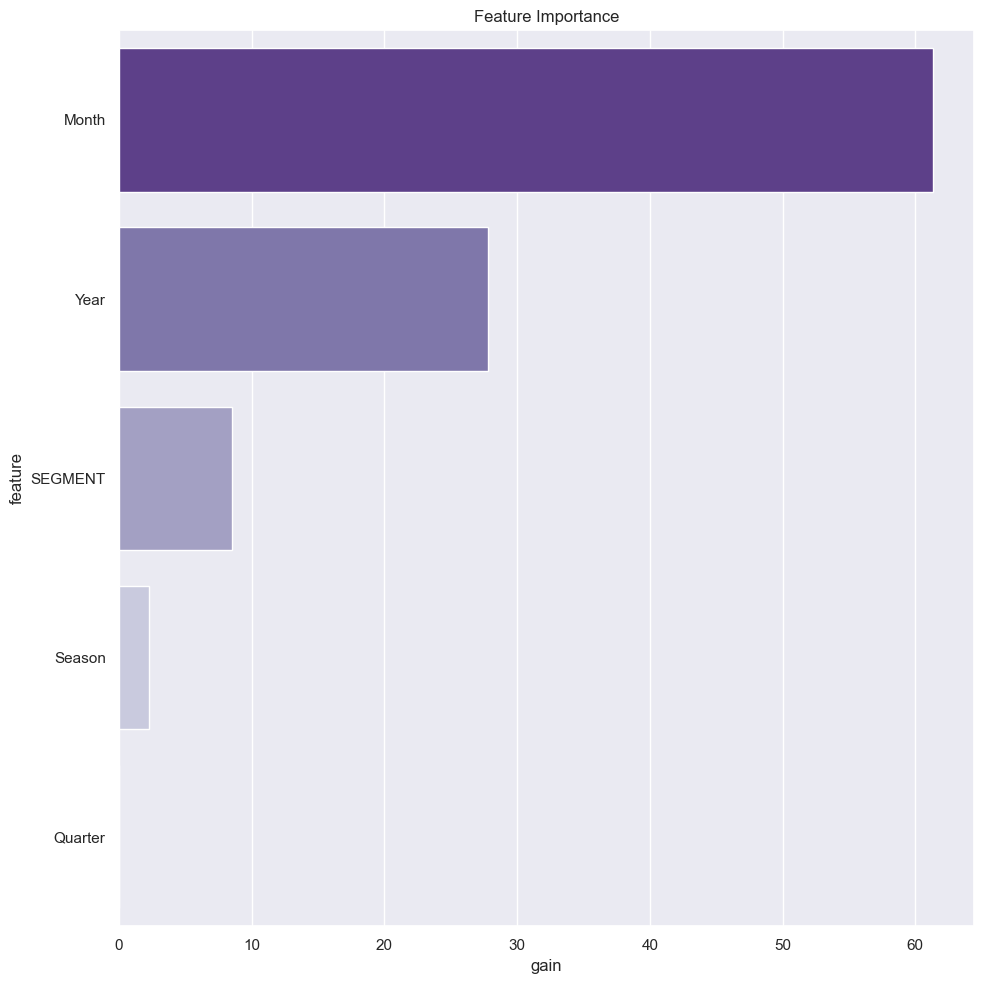

In [207]:
plot_lgb_importances(first_model, plot=True, num=30)

## <span style="color: purple">2.4. Complete Light GBM</span> <a class="anchor" id="section_2_4"></a>


Now, we will try to improve the performance of the model acting upon **Feature selection**: we will try to add existing features that have not been used yet can help the model to better understand the data.

In [235]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [236]:
#We are going to create a new dataframe with the columns that we are going to use for the model
ts_complete_lgbm = original_data[['Week Code','Sales in volume (Lt)', 'Province', 'holiday','SEGMENT','Month', 'Year', 'Season','population']]

In [237]:
#Group df by week code, store code, segment, month, year, season, province, quarter, holiday, mean temp, population and real price in volume, adding sales in volume
ts_complete_lgbm = ts_complete_lgbm.groupby(['Week Code','SEGMENT','Month', 'Year', 'Season','Province', 'holiday','population'])['Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [238]:
ts_complete_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55700 entries, 1 to 116
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SEGMENT               55700 non-null  object 
 1   Month                 55700 non-null  int64  
 2   Year                  55700 non-null  int64  
 3   Season                55700 non-null  object 
 4   Province              55700 non-null  object 
 5   holiday               55700 non-null  float64
 6   population            55700 non-null  int64  
 7   Sales in volume (Lt)  55700 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.8+ MB


In [239]:
ts_complete_lgbm.head() 

SEGMENT  Month  Year  Season                         Province  \
Week Code                                                                   
1          ARTISANS      1  2021  Winter                            Alava   
1          ARTISANS      1  2021  Winter                         Albacete   
1          ARTISANS      1  2021  Winter                         Alicante   
1          ARTISANS      1  2021  Winter  Area Metropolitana de Barcelona   
1          ARTISANS      1  2021  Winter     Area Metropolitana de Madrid   

           holiday  population  Sales in volume (Lt)  
Week Code                                             
1              1.0      251833                     2  
1              1.0      299296                     6  
1              1.0     1478447                    23  
1              1.0     1303135                   172  
1              1.0     1468540                   284

In [240]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in ts_complete_lgbm.columns:
    col_type = ts_complete_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        ts_complete_lgbm[c] = ts_complete_lgbm[c].astype('category')

In [241]:
#Change type od holiday to boolean
ts_complete_lgbm['holiday'] = ts_complete_lgbm['holiday'].astype('bool')

In [242]:
#Reset index to make "Week Code" a regular column
ts_complete_lgbm = ts_complete_lgbm.reset_index()

#Sort DataFrame by "Week Code"
ts_complete_lgbm = ts_complete_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = ts_complete_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = ts_complete_lgbm[~ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = ts_complete_lgbm[ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [243]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((51951, 7), (51951,), (3749, 7), (3749,))

In [244]:
train.head()

SEGMENT  Month  Year  Season                         Province  \
0        ARTISANS      1  2021  Winter                            Alava   
1        ARTISANS      1  2021  Winter                        Castellon   
2  IMPORT PREMIUM      1  2021  Winter                            Avila   
3        ARTISANS      1  2021  Winter                         Alicante   
4        ARTISANS      1  2021  Winter  Area Metropolitana de Barcelona   

   holiday  population  Sales in volume (Lt)  
0     True      251833                     2  
1     True      443161                     4  
2     True      122086                   830  
3     True     1478447                    23  
4     True     1303135                   172

In [245]:
#Train the LightGBM model
second_model = lgb.LGBMRegressor(random_state=384)
second_model.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val)))

TRAIN SMAPE: 56.727264368120515
VALID SMAPE: 55.41144469130206


It is performing pretty bad. Let's check feature importance for trying to improve the model in future sections.

In [246]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(second_model, num=50)

      feature       gain
1       Month  30.300000
4    Province  23.866667
6  population  14.433333
0     SEGMENT  13.466667
2        Year   8.100000
5     holiday   5.000000
3      Season   4.833333


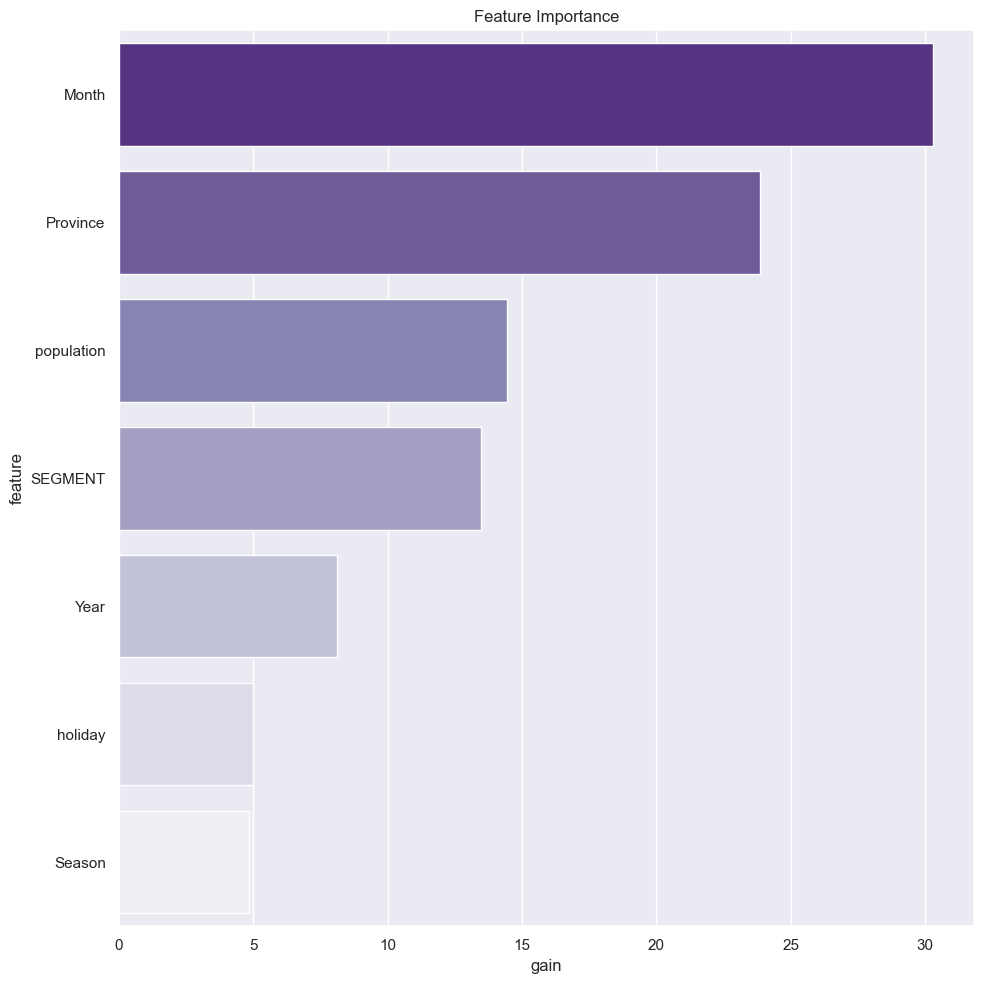

In [247]:
plot_lgb_importances(second_model, plot=True, num=30)

# <span style="color: purple">**3. Modeling for Manufacturer Demand Forecasting**</span> <a class="anchor" id="section_3"></a>

Now, we will follow the same steps as before, but this time we will predict sales for each manufacturer.

## <span style="color: purple">3.1. Simple Autoarima model</span> <a class="anchor" id="section_3_1"></a>

First, we will divide our data into train and test sets. Then we will fit a simple autoarima model to our data and plot the results.

In [248]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [249]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_manufacturer = ts_simple_autoarima.drop(['SEGMENT'], axis=1)
ts_simple_autoarima_manufacturer= ts_simple_autoarima_manufacturer.groupby(['Week Code', 'MANUFACTURER'])['Sales in volume (Lt)'].sum().reset_index()

In [250]:
ts_simple_autoarima_manufacturer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             812 non-null    int64 
 1   MANUFACTURER          812 non-null    object
 2   Sales in volume (Lt)  812 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 19.2+ KB


In [251]:
ts_simple_autoarima_manufacturer = ts_simple_autoarima_manufacturer.set_index('Week Code')

In [252]:
#On this snippet of code, we will train the AutoARIMA model for each manufacturer and store the model in a dictionary. We will comment each step to facilitate its understanding and replication.

#We create a dictionary to store the models and the data for each manufacturer
manufacturer_models = {}
manufacturer_data_dict = {}

#We get the unique manufacturer
unique_manufacturer = ts_simple_autoarima_manufacturer['MANUFACTURER'].unique()

for manufacturer in unique_manufacturer:
    #Extract the data for the manufacturer we are working on
    segment_data = ts_simple_autoarima_manufacturer[ts_simple_autoarima_manufacturer['MANUFACTURER'] == manufacturer]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in volume (Lt)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    manufacturer_data_dict[manufacturer] = {'train': train_data, 'val': val_data}

    #Fit the AutoARIMA model to the train set and store it in the dictionary
    model = auto_arima(train_data)
    manufacturer_models[manufacturer] = model


In [253]:
#We take a look at the models created for each manufacturer
for manufacturer, model in manufacturer_models.items():
    print(f"manufacturer: {manufacturer}")
    print(model.summary())
    print("-------------------")

manufacturer: MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1274.125
Date:                Sat, 01 Jul 2023   AIC                           2556.250
Time:                        17:44:07   BIC                           2567.052
Sample:                             0   HQIC                          2560.631
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.48e+04   1.27e+04      2.745      0.006    9949.570    5.96e+04
ar.L1          0.6381      0.075      8.486      0.000       0.491       0.785
ar.L2          0.1421  

In [254]:
#Let's check that our validation data has been stored correctly
for manufacturer, data in manufacturer_data_dict.items():
    print(f"Manufacturer: {manufacturer}")
    print(data['val'])
    print("-------------------")

Manufacturer: MANUFACTURER 1
Week Code
111    127255
112    127581
113    144440
114    172192
115    151905
116    167928
Name: Sales in volume (Lt), dtype: int64
-------------------
Manufacturer: MANUFACTURER 2
Week Code
111    376132
112    405392
113    437342
114    489176
115    453308
116    433727
Name: Sales in volume (Lt), dtype: int64
-------------------
Manufacturer: MANUFACTURER 3
Week Code
111    689318
112    641325
113    616401
114    735045
115    799914
116    830607
Name: Sales in volume (Lt), dtype: int64
-------------------
Manufacturer: MANUFACTURER 4
Week Code
111    113876
112     81271
113     73972
114     80578
115     83612
116     86344
Name: Sales in volume (Lt), dtype: int64
-------------------
Manufacturer: MANUFACTURER 5
Week Code
111    28945
112    32657
113    34991
114    39110
115    37487
116    37778
Name: Sales in volume (Lt), dtype: int64
-------------------
Manufacturer: MANUFACTURER 6
Week Code
111    869785
112    552573
113    332278
114  

In [255]:
#So, after training our model in our train set, we can use it to make predictions on the validation set. We will store the predictions in a new DataFrame and add it to the dictionary. Also here, the code will be commented in detail to facilitate its understanding and replication.

#We will apply the model to the validation set of each manufacturer
for manufacturer, model in manufacturer_models.items():
    #Extract the validation data for the manufacturer
    val_data = manufacturer_data_dict[manufacturer]['val']

    #Apply the model to the validation data and store the predictions
    predictions = model.predict(n_periods=len(val_data)+1)

    #Create a new DataFrame to store the predictions with the correct index ad then, store it in the dictionary
    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])
    manufacturer_data_dict[manufacturer]['predictions'] = predictions_df

#Print the predictions for each manufacturer
for manufacturer, data in manufacturer_data_dict.items():
    print(f"manufacturer: {manufacturer}")
    print(data['predictions'])
    print("-------------------")

manufacturer: MANUFACTURER 1
             Predictions
Week Code               
111        137381.128650
112        141314.693346
113        144487.514214
114        147070.963656
115        149170.250556
116        150876.856630
-------------------
manufacturer: MANUFACTURER 2
             Predictions
Week Code               
111        502265.398874
112        519986.090603
113        534850.437893
114        547318.846221
115        557777.509707
116        566550.373014
-------------------
manufacturer: MANUFACTURER 3
             Predictions
Week Code               
111        769068.831416
112        794874.502259
113        813959.133457
114        828073.207461
115        838511.296775
116        846230.804871
-------------------
manufacturer: MANUFACTURER 4
            Predictions
Week Code              
111        99719.728094
112        92686.950122
113        88477.921362
114        85958.870827
115        84451.250909
116        83548.959436
-------------------
manufacturer

In [256]:
#After applying our trained autoarima models for each manufacturer to each validation set, we should check how are they performing. For that, we will calculate the MSE and MAPE for each manufacturer model. We will also comment each step to facilitate its understanding and replication.

#We create the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We initialize 2 list which will store the errors for each of the manufacturer' models
mse_list_man = []
mape_list_man = []

#We make an iteration over each manufacturer
for manufacturer in manufacturer_data_dict.keys():

    #First we get the true values of the validation set, which we stored in the dictionary
    y_true = manufacturer_data_dict[manufacturer]['val']
    
    #Then, we get the predictions of the validation set after applying the model
    y_pred = manufacturer_data_dict[manufacturer]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_man.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_man.append(mape)

    #Print the results for each manufacturer
    print(f"manufacturer: {manufacturer}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

manufacturer: MANUFACTURER 1
MSE: 203406980.6156443
MAPE: 7.549674289083237%
-------------------
manufacturer: MANUFACTURER 2
MSE: 11747642136.206366
MAPE: 24.942191736470868%
-------------------
manufacturer: MANUFACTURER 3
MSE: 13225827138.48969
MAPE: 14.487440861310267%
-------------------
manufacturer: MANUFACTURER 4
MSE: 96436011.79091388
MAPE: 9.501129109840123%
-------------------
manufacturer: MANUFACTURER 5
MSE: 7861220.36734461
MAPE: 7.585755348476915%
-------------------
manufacturer: MANUFACTURER 6
MSE: 24452524256.03593
MAPE: 39.4514390834674%
-------------------
manufacturer: OTHER MANUFACTURERS
MSE: 8652933.57858587
MAPE: 5.27560930940966%
-------------------


Let's take a look at the results:

**MANUFACTURER 1**:
MAPE: **7.55%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

**MANUFACTURER 2**:
MAPE: **24.94%**
The MAPE is high, suggesting that the model performs poorly in predicting sales for this manufacturer.

**MANUFACTURER 3**:
MAPE: **14.49%**
The MAPE is acceptable, but it can be improved.

**MANUFACTURER 4**:
MAPE: **9.50%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

**MANUFACTURER 5**:
MAPE: **7.59%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

**MANUFACTURER 6**:
MAPE: **39.45%**
The MAPE is really high, suggesting that the model performs poorly in predicting sales for this manufacturer.

**OTHER MANUFACTURERS**:
MAPE: **5.28%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

## <span style="color: purple">3.2. Autoarima model with hyperparameter tuning</span> <a class="anchor" id="section_3_2"></a>

As we have seen, the simple Autoarima model can be used to predict sales for some manufacturers, but it does not perform well for others. So, we will try to improve the performance of the model by tuning the hyperparameters.

In [257]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each manufacturer. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
manufacturer_models_2 = {}
manufacturer_data_dict_2 = {}

#We get the unique manufacturers
unique_manufacturers = ts_simple_autoarima_manufacturer['MANUFACTURER'].unique()

for manufacturer in unique_manufacturers:
    #Extract the data for the manufacturer we are working on
    manufacturer_data = ts_simple_autoarima_manufacturer[ts_simple_autoarima_manufacturer['MANUFACTURER'] == manufacturer]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(manufacturer_data['Sales in volume (Lt)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    manufacturer_data_dict_2[manufacturer] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each manufacturer in the dictionary
    manufacturer_models_2[manufacturer] = best_model

In [258]:
#We take a look at the best models found for each manufacturer
for manufacturer, best_model in manufacturer_models_2.items():
    print(f"manufacturer: {manufacturer}")
    print(best_model.summary())
    print("-------------------")

manufacturer: MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1274.125
Date:                Sat, 01 Jul 2023   AIC                           2556.250
Time:                        17:51:26   BIC                           2567.052
Sample:                             0   HQIC                          2560.631
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.48e+04   1.27e+04      2.745      0.006    9949.570    5.96e+04
ar.L1          0.6381      0.075      8.486      0.000       0.491       0.785
ar.L2          0.1421  

In [259]:
#We will apply the model to the validation set of each manufacturer so, as we have done in the autoarima model, we take a look at the validation set for each manufacturer
for manufacturer, data in manufacturer_data_dict_2.items():
    print(f"manufacturer: {manufacturer}")
    print(data['val'])
    print("-------------------")

manufacturer: MANUFACTURER 1
Week Code
111    127255
112    127581
113    144440
114    172192
115    151905
116    167928
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 2
Week Code
111    376132
112    405392
113    437342
114    489176
115    453308
116    433727
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 3
Week Code
111    689318
112    641325
113    616401
114    735045
115    799914
116    830607
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 4
Week Code
111    113876
112     81271
113     73972
114     80578
115     83612
116     86344
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 5
Week Code
111    28945
112    32657
113    34991
114    39110
115    37487
116    37778
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 6
Week Code
111    869785
112    552573
113    332278
114  

In [260]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each manufacturer and store the predictions in the dictionary.

for manufacturer, best_model in manufacturer_models_2.items():
    
    val_data = manufacturer_data_dict_2[manufacturer]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    manufacturer_data_dict_2[manufacturer]['predictions'] = predictions_df

#Print predictions of each manufacturer
for manufacturer, data in manufacturer_data_dict_2.items():
    print(f"Manufacturer: {manufacturer}")
    print(data['predictions'])
    print("-------------------")

Manufacturer: MANUFACTURER 1
             Predictions
Week Code               
111        137381.128650
112        141314.693346
113        144487.514214
114        147070.963656
115        149170.250556
116        150876.856630
-------------------
Manufacturer: MANUFACTURER 2
             Predictions
Week Code               
111        401607.228491
112        409536.977833
113        423210.106547
114        434481.193298
115        443772.219456
116        451431.034350
-------------------
Manufacturer: MANUFACTURER 3
             Predictions
Week Code               
111        692061.677944
112        694596.016916
113        697130.355887
114        699664.694859
115        702199.033831
116        704733.372803
-------------------
Manufacturer: MANUFACTURER 4
            Predictions
Week Code              
111        90700.264993
112        87676.195845
113        89943.621367
114        89516.588550
115        86947.414276
116        85238.626793
-------------------
Manufacturer

In [261]:
#We will initialize lists to store MSE and MAPE for each manufacturer
mse_list_man_2 = []
mape_list_man_2 = []

#Iterate over each manufacturer
for manufacturer in manufacturer_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = manufacturer_data_dict_2[manufacturer]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = manufacturer_data_dict_2[manufacturer]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_man_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_man_2.append(mape)

    #Print the results for each manufacturer
    print(f"manufacturer: {manufacturer}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

manufacturer: MANUFACTURER 1
MSE: 203406980.6156443
MAPE: 7.549674289083237%
-------------------
manufacturer: MANUFACTURER 2
MSE: 710294057.248967
MAPE: 4.732194875613879%
-------------------
manufacturer: MANUFACTURER 3
MSE: 6001118090.471604
MAPE: 8.997461215997243%
-------------------
manufacturer: MANUFACTURER 4
MSE: 154246519.93191427
MAPE: 11.031149049509008%
-------------------
manufacturer: MANUFACTURER 5
MSE: 7861220.36734461
MAPE: 7.585755348476915%
-------------------
manufacturer: MANUFACTURER 6
MSE: 8032771653.687619
MAPE: 18.379138114475943%
-------------------
manufacturer: OTHER MANUFACTURERS
MSE: 8652933.57858587
MAPE: 5.27560930940966%
-------------------


So, let's take a look to the errors of the new models:
- **MANUFACTURER 1, MANUFACTURER 5  and OTHER MANUFACTURERS**: MAPE: **7.55%, 7.59% and 5.28%** The MAPE is the same as the simple Autoarima model, so we can say that the model performs equally well in predicting sales for these manufacturers.

- **MANUFACTURER 2**:
MAPE: **4.73%**
Mape has decreased significantly (previous one 24.94%), so we can say that the model performs much better in predicting sales for this manufacturer.

- **MANUFACTURER 3**:
MAPE: **8.99%**
MAPE has also decreased (previous one 14.49%), so we can say that the model performs better in predicting sales for this manufacturer.

- **MANUFACTURER 4**:
MAPE: **11.03%**
MAPE has increased (previous one 9.50%), so we can say that the model performs worse in predicting sales for this manufacturer.

- **MANUFACTURER 6**:
MAPE: **18.38%**
MAPE has decreased significantly (previous one 39.45%), so we can say that the model performs much better in predicting sales for this manufacturer.

The conclusions that we can draw from this are simmilar to the segment models. Overall, these last models are performing better than the simple Autoarima model, so we can say that they are **potential good models to predict sales for all manufacturers** despite, as we know, they can be improved for some manufacturers (specially Manufacturer 6)

## <span style="color: purple">3.3. Simple LightGBM</span> <a class="anchor" id="section_3_3"></a>

Now, instead of applying an ARIMA type model, we will apply a LightGBM model. At this point, we will apply the simplest one

In [262]:
#We create a copy
ts_simple_lgbm = ts_simple_data.copy()

In [263]:
ts_simple_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             6702 non-null   int64 
 1   SEGMENT               6702 non-null   object
 2   MANUFACTURER          6702 non-null   object
 3   Month                 6702 non-null   int64 
 4   Year                  6702 non-null   int64 
 5   Season                6702 non-null   object
 6   Quarter               6702 non-null   int64 
 7   Sales in volume (Lt)  6702 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 419.0+ KB


In [264]:
#Drop manufacturer column, and group sales in volume
ts_simple_lgbm = ts_simple_lgbm.drop(['SEGMENT'], axis=1)

manufacturer_sales_lgbm= ts_simple_lgbm.groupby(['Week Code', 'MANUFACTURER', 'Month', 'Year', 'Season', 'Quarter'])['Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [265]:
#We convert the categorical variables to the category type
for c in manufacturer_sales_lgbm.columns:
    col_type = manufacturer_sales_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        manufacturer_sales_lgbm[c] = manufacturer_sales_lgbm[c].astype('category')

In [266]:
manufacturer_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812 entries, 1 to 116
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   MANUFACTURER          812 non-null    category
 1   Month                 812 non-null    int64   
 2   Year                  812 non-null    int64   
 3   Season                812 non-null    category
 4   Quarter               812 non-null    int64   
 5   Sales in volume (Lt)  812 non-null    int64   
dtypes: category(2), int64(4)
memory usage: 33.9 KB


In [267]:
manufacturer_sales_lgbm.head()

MANUFACTURER  Month  Year  Season  Quarter  Sales in volume (Lt)
Week Code                                                                    
1          MANUFACTURER 1      1  2021  Winter        1                115093
1          MANUFACTURER 2      1  2021  Winter        1                404544
1          MANUFACTURER 3      1  2021  Winter        1                593595
1          MANUFACTURER 4      1  2021  Winter        1                 79745
1          MANUFACTURER 5      1  2021  Winter        1                 25677

In [268]:
#Reset index to make "Week Code" a regular column
manufacturer_sales_lgbm = manufacturer_sales_lgbm.reset_index()

#Sort DataFrame by "Week Code"
manufacturer_sales_lgbm = manufacturer_sales_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = manufacturer_sales_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = manufacturer_sales_lgbm[~manufacturer_sales_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = manufacturer_sales_lgbm[manufacturer_sales_lgbm['Week Code'].isin(last_week_codes)]

#Drop the "Week Code" column
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [269]:
train.head()

MANUFACTURER  Month  Year  Season  Quarter  Sales in volume (Lt)
0  MANUFACTURER 1      1  2021  Winter        1                115093
1  MANUFACTURER 2      1  2021  Winter        1                404544
2  MANUFACTURER 3      1  2021  Winter        1                593595
3  MANUFACTURER 4      1  2021  Winter        1                 79745
4  MANUFACTURER 5      1  2021  Winter        1                 25677

In [270]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((756,), (756, 5), (56,), (56, 5))

At this point, what we have are 756 training examples with 5 features, and 56 validation examples with the same 5 features. The target variable have the same shape as the features, but with only one column (sales volume)

In [271]:
#Train the LightGBM model
first_model_man = lgb.LGBMRegressor(random_state=384)
first_model_man.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, first_model_man.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model_man.predict(X_val)))

TRAIN SMAPE: 16.869539881038396
VALID SMAPE: 24.421230375771078


This model is not working bad, but it is not good enough.

In [272]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model_man, num=50)

        feature       gain
1         Month  61.733129
2          Year  27.415644
0  MANUFACTURER   8.550613
3        Season   2.300613
4       Quarter   0.000000


In [273]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((5, 2), (4, 2), (4, 2))

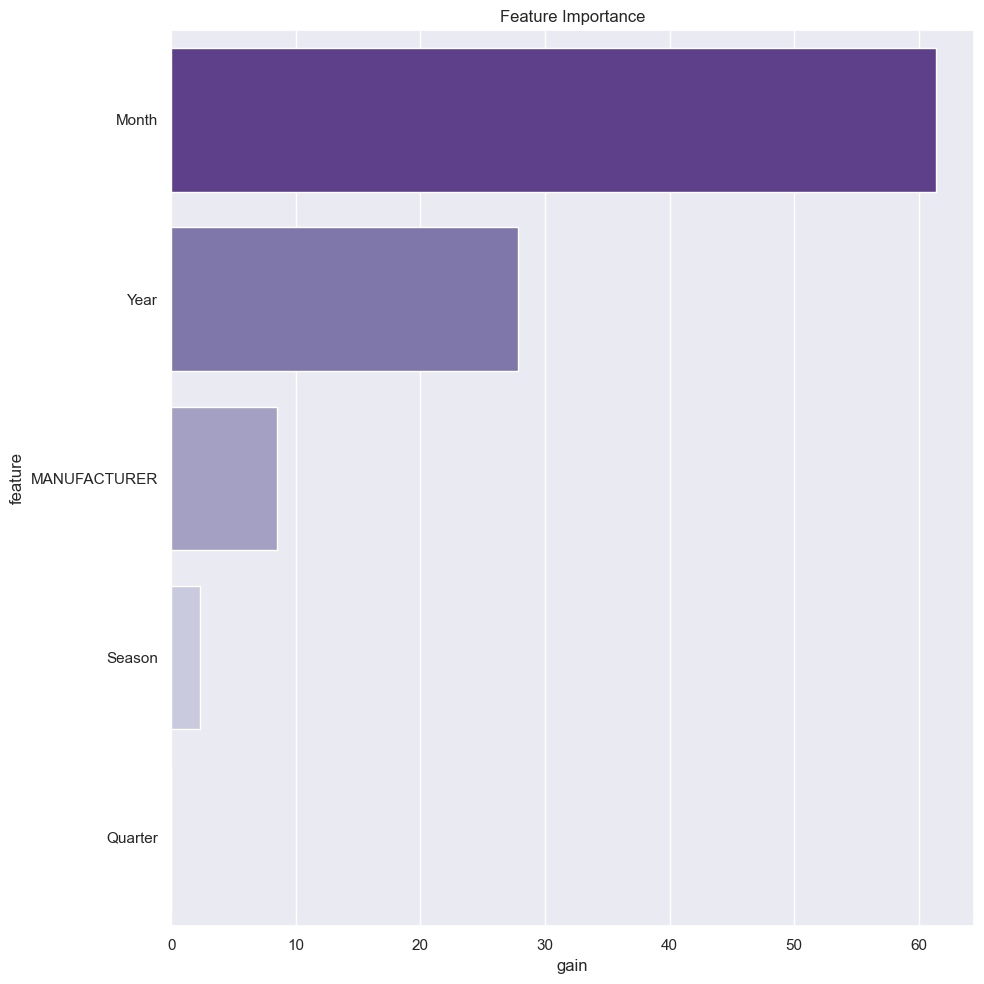

In [274]:
plot_lgb_importances(first_model, plot=True, num=30)

## <span style="color: purple">3.4. Complete Light GBM</span> <a class="anchor" id="section_3_4"></a>

Now, we will try to improve the performance of the model acting upon **Feature selection**: we will try to add existing features that have not been used yet can help the model to better understand the data.

In [275]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [276]:
#We are going to create a new dataframe with the columns that we are going to use for the model
ts_complete_lgbm = original_data[['Week Code','Sales in volume (Lt)', 'holiday','MANUFACTURER','Month','mean temp','Season']]

In [277]:
#Group df by week code, store code, segment, month, year, season, province, quarter, holiday, mean temp, population and real price in volume, adding sales in volume
ts_complete_lgbm = ts_complete_lgbm.groupby(['Week Code','MANUFACTURER','Month','holiday','Season', 'mean temp'])['Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [278]:
ts_complete_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36680 entries, 1 to 116
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MANUFACTURER          36680 non-null  object 
 1   Month                 36680 non-null  int64  
 2   holiday               36680 non-null  float64
 3   Season                36680 non-null  object 
 4   mean temp             36680 non-null  float64
 5   Sales in volume (Lt)  36680 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 2.0+ MB


In [279]:
ts_complete_lgbm.head() 

MANUFACTURER  Month  holiday  Season  mean temp  \
Week Code                                                      
1          MANUFACTURER 1      1      0.0  Winter  11.685714   
1          MANUFACTURER 1      1      1.0  Winter   5.485714   
1          MANUFACTURER 1      1      1.0  Winter   5.500000   
1          MANUFACTURER 1      1      1.0  Winter   6.000000   
1          MANUFACTURER 1      1      1.0  Winter   6.028571   

           Sales in volume (Lt)  
Week Code                        
1                          4481  
1                            10  
1                            42  
1                            11  
1                           864

In [280]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in ts_complete_lgbm.columns:
    col_type = ts_complete_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        ts_complete_lgbm[c] = ts_complete_lgbm[c].astype('category')

In [281]:
#Change type od holiday to boolean
ts_complete_lgbm['holiday'] = ts_complete_lgbm['holiday'].astype('bool')

In [282]:
#Reset index to make "Week Code" a regular column
ts_complete_lgbm = ts_complete_lgbm.reset_index()

#Sort DataFrame by "Week Code"
ts_complete_lgbm = ts_complete_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = ts_complete_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = ts_complete_lgbm[~ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = ts_complete_lgbm[ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [283]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((34185, 5), (34185,), (2495, 5), (2495,))

In [284]:
train.head()

MANUFACTURER  Month  holiday  Season  mean temp  Sales in volume (Lt)
0  MANUFACTURER 1      1    False  Winter  11.685714                  4481
1  MANUFACTURER 1      1     True  Winter   6.514286                    79
2  MANUFACTURER 1      1     True  Winter   5.485714                    10
3  MANUFACTURER 4      1     True  Winter   9.142857                   124
4  MANUFACTURER 1      1     True  Winter   6.000000                    11

In [285]:
#Train the LightGBM model
second_model_man = lgb.LGBMRegressor(random_state=384)
second_model_man.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, second_model_man.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, second_model_man.predict(X_val)))

TRAIN SMAPE: 104.65627578802031
VALID SMAPE: 103.14591020383612


We have been trying to add and drop features of the model the result has been quite horrible. Despite that, we have decided to keep it a really bad model to also help us on future iterations, allowing us to further understand variables importance.

In [286]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(second_model_man, num=50)

        feature       gain
4     mean temp  63.300000
1         Month  19.966667
0  MANUFACTURER  10.300000
2       holiday   4.800000
3        Season   1.633333


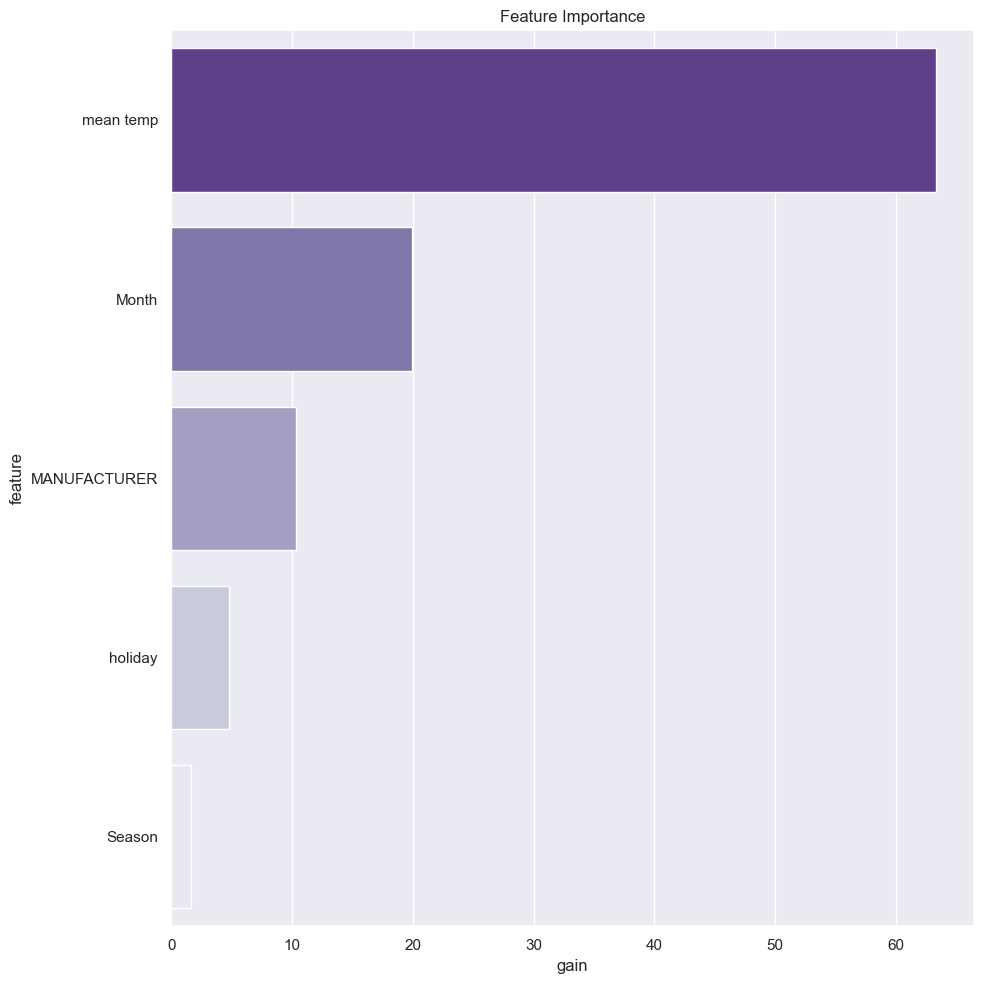

In [287]:
plot_lgb_importances(second_model_man, plot=True, num=30)

# <span style="color: purple">**4. Modeling for Stores Demand Forecasting**</span> <a class="anchor" id="section_4"></a>

Despite it is not require for the challenge, we will try to predict sales for each store considering also segments and manufacturers (so it is like applying the previous things done but altogether). We will apply just LightGBM models, due to the fact that for the multiple time series ARIMA models we have to iterate over all the stores and segments, and it would be really inefficient. **Also, we have decided to apply LightGBM because it has performed poorly trying to predict sales for manufacturers and for segments separately, so we like to see if it performs better when we try to predict sales for all of them together.**

## <span style="color: purple">4.1. LightGBM</span> <a class="anchor" id="section_4_1"></a>

In [288]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [289]:
#We are going to create a new dataframe with the columns that we are going to use for the model
stores_lgbm = original_data[['Week Code','Store Code','Province', 'Sales in volume (Lt)', 'holiday','SEGMENT','Month','mean temp','precipitation','liters/person', 'MANUFACTURER']]

In [290]:
#Group and add sales
stores_lgbm = stores_lgbm.groupby(['Week Code','Store Code','Month', 'Province','holiday','SEGMENT', 'precipitation',  'mean temp', 'MANUFACTURER'])['liters/person','Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [291]:
stores_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284464 entries, 1 to 116
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store Code            1284464 non-null  int64  
 1   Month                 1284464 non-null  int64  
 2   Province              1284464 non-null  object 
 3   holiday               1284464 non-null  float64
 4   SEGMENT               1284464 non-null  object 
 5   precipitation         1284464 non-null  float64
 6   mean temp             1284464 non-null  float64
 7   MANUFACTURER          1284464 non-null  object 
 8   liters/person         1284464 non-null  float64
 9   Sales in volume (Lt)  1284464 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 107.8+ MB


In [292]:
stores_lgbm.head() 

Store Code  Month Province  holiday    SEGMENT  precipitation  \
Week Code                                                                  
1                   1      1  Almeria      1.0    CELIACS       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0  FLAVOURED       0.585714   

           mean temp    MANUFACTURER  liters/person  Sales in volume (Lt)  
Week Code                                                                  
1          12.571429  MANUFACTURER 1       0.000000                     0  
1          12.571429  MANUFACTURER 1       0.000018                    10  
1          12.571429  MANUFACTURER 3       0.000040                    22  
1          12.571429  MANUFACTURER 6       0.000016                     9  
1          12.571429  MANUFACTURER 2       0.000029                    16

In [293]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in stores_lgbm.columns:
    col_type = stores_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        stores_lgbm[c] = stores_lgbm[c].astype('category')

In [294]:
#Change type od holiday to boolean
stores_lgbm['holiday'] = stores_lgbm['holiday'].astype('bool')

In [295]:
#Reset index to make "Week Code" a regular column
stores_lgbm = stores_lgbm.reset_index()

#Sort DataFrame by "Week Code"
stores_lgbm = stores_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = stores_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = stores_lgbm[~stores_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = stores_lgbm[stores_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [296]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1193690, 9), (1193690,), (90774, 9), (90774,))

In [297]:
train.head()

Store Code  Month Province  holiday    SEGMENT  precipitation  mean temp  \
0           1      1  Almeria     True    CELIACS       0.585714  12.571429   
1           1      1  Almeria     True      EXTRA       0.585714  12.571429   
2           1      1  Almeria     True      EXTRA       0.585714  12.571429   
3           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   
4           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   

     MANUFACTURER  liters/person  Sales in volume (Lt)  
0  MANUFACTURER 1       0.000000                     0  
1  MANUFACTURER 3       0.000040                    22  
2  MANUFACTURER 6       0.000016                     9  
3  MANUFACTURER 2       0.000029                    16  
4  MANUFACTURER 3       0.000040                    22

In [298]:
#Train the LightGBM model
model_stores = lgb.LGBMRegressor(random_state=384)
model_stores.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, model_stores.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, model_stores.predict(X_val)))

TRAIN SMAPE: 26.00421903540587
VALID SMAPE: 26.567815635768614


In [299]:
#Get the model parameters
model_stores.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 384,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

After many iterations, this is the best model that we have been able to found. It is not working bad, but it is not good enough. After checking the importance of the features we will apply hyperparameter tuning to try to try to improve the performance of the model.

In [300]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(model_stores, num=50)

         feature       gain
8  liters/person  21.533333
6      mean temp  20.300000
2       Province  18.700000
5  precipitation  12.566667
1          Month  11.766667
0     Store Code   9.900000
7   MANUFACTURER   2.700000
3        holiday   1.300000
4        SEGMENT   1.233333


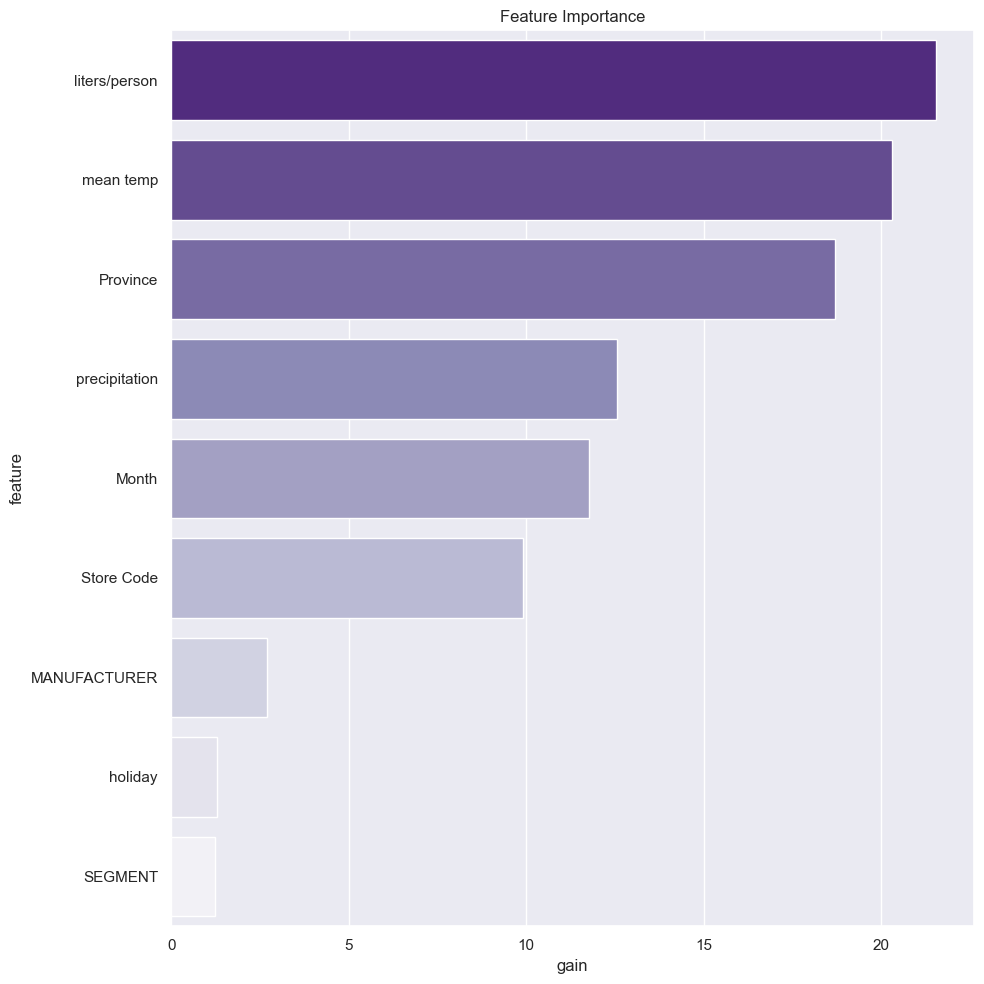

In [301]:
plot_lgb_importances(model_stores, plot=True, num=30)

## <span style="color: purple">4.2. LightGBM with Finetuning</span> <a class="anchor" id="section_4_2"></a>

At this section we are going to try to improve the model for the already selected data, applying hyperparameter tuning. We will use the same data as before, but we will try to find the best hyperparameters for our model.

In [302]:
#We are going to create a new dataframe with the columns that we are going to use for the model
stores_lgbm_finetuning = original_data[['Week Code','Store Code','Province', 'Sales in volume (Lt)', 'holiday','SEGMENT','Month','mean temp','precipitation','liters/person', 'MANUFACTURER']]

In [303]:
#Group and add sales
stores_lgbm_finetuning = stores_lgbm_finetuning.groupby(['Week Code','Store Code','Month', 'Province','holiday','SEGMENT', 'precipitation',  'mean temp', 'MANUFACTURER'])['liters/person','Sales in volume (Lt)'].sum().reset_index().set_index("Week Code")

In [304]:
stores_lgbm_finetuning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284464 entries, 1 to 116
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store Code            1284464 non-null  int64  
 1   Month                 1284464 non-null  int64  
 2   Province              1284464 non-null  object 
 3   holiday               1284464 non-null  float64
 4   SEGMENT               1284464 non-null  object 
 5   precipitation         1284464 non-null  float64
 6   mean temp             1284464 non-null  float64
 7   MANUFACTURER          1284464 non-null  object 
 8   liters/person         1284464 non-null  float64
 9   Sales in volume (Lt)  1284464 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 107.8+ MB


In [305]:
stores_lgbm_finetuning.head() 

Store Code  Month Province  holiday    SEGMENT  precipitation  \
Week Code                                                                  
1                   1      1  Almeria      1.0    CELIACS       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0  FLAVOURED       0.585714   

           mean temp    MANUFACTURER  liters/person  Sales in volume (Lt)  
Week Code                                                                  
1          12.571429  MANUFACTURER 1       0.000000                     0  
1          12.571429  MANUFACTURER 1       0.000018                    10  
1          12.571429  MANUFACTURER 3       0.000040                    22  
1          12.571429  MANUFACTURER 6       0.000016                     9  
1          12.571429  MANUFACTURER 2       0.000029                    16

In [306]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in stores_lgbm_finetuning.columns:
    col_type = stores_lgbm_finetuning[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        stores_lgbm_finetuning[c] = stores_lgbm_finetuning[c].astype('category')

In [307]:
#Change type od holiday to boolean
stores_lgbm_finetuning['holiday'] = stores_lgbm_finetuning['holiday'].astype('bool')

In [308]:
#Reset index to make "Week Code" a regular column
stores_lgbm_finetuning = stores_lgbm_finetuning.reset_index()

#Sort DataFrame by "Week Code"
stores_lgbm_finetuning = stores_lgbm_finetuning.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = stores_lgbm_finetuning['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = stores_lgbm_finetuning[~stores_lgbm_finetuning['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = stores_lgbm_finetuning[stores_lgbm_finetuning['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in volume (Lt)']
X_train = train[cols]
Y_train = train['Sales in volume (Lt)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in volume (Lt)']

In [309]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1193690, 9), (1193690,), (90774, 9), (90774,))

In [310]:
train.head()

Store Code  Month Province  holiday    SEGMENT  precipitation  mean temp  \
0           1      1  Almeria     True    CELIACS       0.585714  12.571429   
1           1      1  Almeria     True      EXTRA       0.585714  12.571429   
2           1      1  Almeria     True      EXTRA       0.585714  12.571429   
3           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   
4           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   

     MANUFACTURER  liters/person  Sales in volume (Lt)  
0  MANUFACTURER 1       0.000000                     0  
1  MANUFACTURER 3       0.000040                    22  
2  MANUFACTURER 6       0.000016                     9  
3  MANUFACTURER 2       0.000029                    16  
4  MANUFACTURER 3       0.000040                    22

In [311]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

#Define the parameter grid for randomized search
param_grid = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [-1, 5, 10, 50],
    'num_leaves': [31, 50, 75, 100],
    'n_estimators': [100, 200, 300, 500],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'random_state': [42, 384, 999, 1234]
}


#Create an instance of the LightGBM regressor
finetuned_model = lgb.LGBMRegressor()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(finetuned_model, param_distributions=param_grid, cv=30, scoring=lgbm_smape)
random_search.fit(X_train, Y_train)

#Get the best model from the search
best_model = random_search.best_estimator_

#Evaluate the best model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, best_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, best_model.predict(X_val)))

TRAIN SMAPE: 55.71776384929928
VALID SMAPE: 57.34011818823337


In [312]:
#get info of params of best model
best_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': None,
 'random_state': 384,
 'reg_alpha': 1.0,
 'reg_lambda': 0.1,
 'silent': 'warn',
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

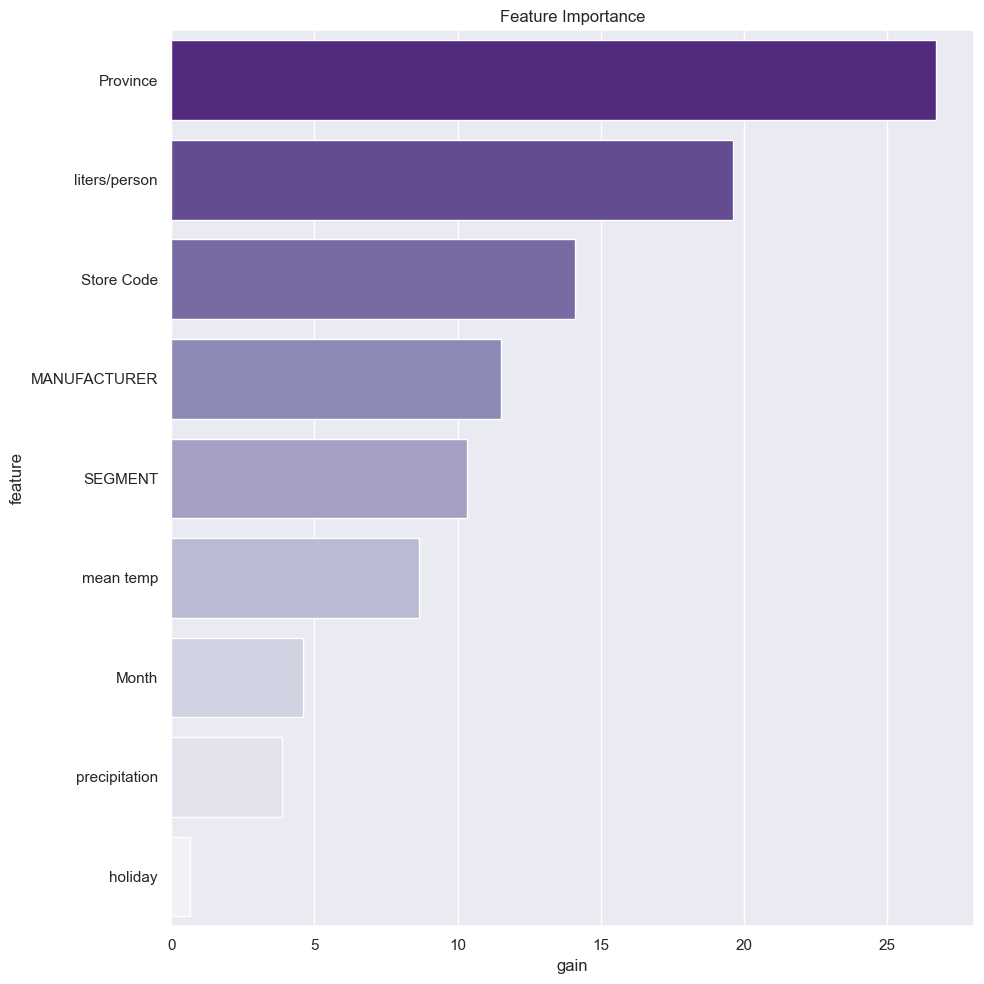

In [313]:
plot_lgb_importances(best_model, plot=True, num=30)

We have been applying hyperparameter tuning for long, but the model is not working better than the previous one. So, we will keep the previous one as the best model for this section.

We have been, at first, using grid search for hyperparameter tuning, but it was taking too long. So, we have decided to use random search instead.

It is pretty interesting to see the differences in feature importance between the two models that we have created for the stores. Special attention to the fact that mean temperature and precipation, which have not been really important in the separated models are now some of the most important features.

# <span style="color: purple">**5. Forecasting applying the best models**</span> <a class="anchor" id="section_5"></a>
## 

Now, we will apply the best models that we have found to predict sales for segments, and for manufacturers. The forecasting will be done for the short term (4 weeks) and for the long term (rest of 2023 and 2024)

The long term prediction has been done in pursuit of the challenge, but it is not really useful, because the data that we have to train the model is not enough to predict sales for the long term. So, we recommend to use the short term prediction.

In [84]:
#First, we will create a dictionary mapping each Week Code to the corresponding Date
week_dict = {1:"03/01/2021", 2: "10/01/2021", 3: "17/01/2021", 4: "24/01/2021", 5: "31/01/2021", 6: "07/02/2021", 7: "14/02/2021", 8: "21/02/2021",
                9: "28/02/2021", 10: "07/03/2021", 11: "14/03/2021", 12: "21/03/2021", 13: "28/03/2021", 14: "04/04/2021", 15: "11/04/2021", 16: "18/04/2021",
                17: "25/04/2021", 18: "02/05/2021", 19: "09/05/2021", 20: "16/05/2021", 21: "23/05/2021", 22: "30/05/2021", 23: "06/06/2021", 24: "13/06/2021",
                25: "20/06/2021", 26: "27/06/2021", 27: "04/07/2021", 28: "11/07/2021", 29: "18/07/2021", 30: "25/07/2021", 31: "01/08/2021", 32: "08/08/2021",
                33: "15/08/2021", 34: "22/08/2021", 35: "29/08/2021", 36: "05/09/2021", 37: "12/09/2021", 38: "19/09/2021", 39: "26/09/2021", 40: "03/10/2021",
                41: "10/10/2021", 42: "17/10/2021", 43: "24/10/2021", 44: "31/10/2021", 45: "07/11/2021", 46: "14/11/2021", 47: "21/11/2021", 48: "28/11/2021",
                49: "05/12/2021", 50: "12/12/2021", 51: "19/12/2021", 52: "26/12/2021", 53: "02/01/2022", 54: "09/01/2022", 55: "16/01/2022", 56: "23/01/2022",
                57: "30/01/2022", 58: "06/02/2022", 59: "13/02/2022", 60: "20/02/2022", 61: "27/02/2022", 62: "06/03/2022", 63: "13/03/2022", 64: "20/03/2022",
                65: "27/03/2022", 66: "03/04/2022", 67: "10/04/2022", 68: "17/04/2022", 69: "24/04/2022", 70: "01/05/2022", 71: "08/05/2022", 72: "15/05/2022",
                73: "22/05/2022", 74: "29/05/2022", 75: "05/06/2022", 76: "12/06/2022", 77: "19/06/2022", 78: "26/06/2022", 79: "03/07/2022", 80: "10/07/2022",
                81: "17/07/2022", 82: "24/07/2022", 83: "31/07/2022", 84: "07/08/2022", 85: "14/08/2022", 86: "21/08/2022", 87: "28/08/2022", 88: "04/09/2022",
                89: "11/09/2022", 90: "18/09/2022", 91: "25/09/2022", 92: "02/10/2022", 93: "09/10/2022", 94: "16/10/2022", 95: "23/10/2022", 96: "30/10/2022",
                97: "06/11/2022", 98: "13/11/2022", 99: "20/11/2022", 100: "27/11/2022", 101: "04/12/2022", 102: "11/12/2022", 103: "18/12/2022", 104: "25/12/2022",
                105: "01/01/2023", 106: "08/01/2023", 107: "15/01/2023", 108: "22/01/2023", 109: "29/01/2023", 110: "05/02/2023", 111: "12/02/2023", 112: "19/02/2023",
                113: "26/02/2023", 114: "05/03/2023", 115: "12/03/2023", 116: "19/03/2023", 117: "26/03/2023", 118: "02/04/2023", 119: "09/04/2023", 120: "16/04/2023",
                121: "23/04/2023", 122: "30/04/2023", 123: "07/05/2023", 124: "14/05/2023", 125: "21/05/2023", 126: "28/05/2023", 127: "04/06/2023", 128: "11/06/2023",
                129: "18/06/2023", 130: "25/06/2023", 131: "02/07/2023", 132: "09/07/2023", 133: "16/07/2023", 134: "23/07/2023", 135: "30/07/2023", 136: "06/08/2023",
                137: "13/08/2023", 138: "20/08/2023", 139: "27/08/2023", 140: "03/09/2023", 141: "10/09/2023", 142: "17/09/2023", 143: "24/09/2023", 144: "01/10/2023",
                145: "08/10/2023", 146: "15/10/2023", 147: "22/10/2023", 148: "29/10/2023", 149: "05/11/2023", 150: "12/11/2023", 151: "19/11/2023", 152: "26/11/2023",
                153: "03/12/2023", 154: "10/12/2023", 155: "17/12/2023", 156: "24/12/2023", 157: "31/12/2023", 158: "07/01/2024", 159: "14/01/2024", 160: "21/01/2024",
                161: "28/01/2024", 162: "04/02/2024", 163: "11/02/2024", 164: "18/02/2024", 165: "25/02/2024", 166: "03/03/2024", 167: "10/03/2024", 168: "17/03/2024",
                169: "24/03/2024", 170: "31/03/2024", 171: "07/04/2024", 172: "14/04/2024", 173: "21/04/2024", 174: "28/04/2024", 175: "05/05/2024", 176: "12/05/2024",
                177: "19/05/2024", 178: "26/05/2024", 179: "02/06/2024", 180: "09/06/2024", 181: "16/06/2024", 182: "23/06/2024", 183: "30/06/2024", 184: "07/07/2024",
                185: "14/07/2024", 186: "21/07/2024", 187: "28/07/2024", 188: "04/08/2024", 189: "11/08/2024", 190: "18/08/2024", 191: "25/08/2024", 192: "01/09/2024",
                193: "08/09/2024", 194: "15/09/2024", 195: "22/09/2024", 196: "29/09/2024", 197: "06/10/2024", 198: "13/10/2024", 199: "20/10/2024", 200: "27/10/2024",
                201: "03/11/2024", 202: "10/11/2024", 203: "17/11/2024", 204: "24/11/2024", 205: "01/12/2024", 206: "08/12/2024", 207: "15/12/2024", 208: "22/12/2024",
                209: "29/12/2024"}

## <span style="color: purple">5.1. Short Term Forecasting for segments</span> <a class="anchor" id="section_5_1"></a>

At this point, we will apply our best ARIMA models to predict sales for each segment for the next 4 weeks.

In [315]:
#Now we will predict for the next 4 weeks for each segment. We will create a new DataFrame to store the predictions for each segment.

#Create a new DataFrame for predictions
predictions_df_segments = pd.DataFrame(columns=["Week Code", "Segment", "Predictions"])

#Iterate over each segment and its best model
for segment, best_model in segment_models_2.items():
    #Get the last available week code for the segment
    last_week_code = segment_data_dict_2[segment]['val'].index[-1]
    
    # Generate predictions for weeks 117, 118, 119, and 120
    future_week_codes = range(last_week_code+1, last_week_code+5)
    predictions = best_model.predict(n_periods=4)
    
    #Add the predicted values to the DataFrame
    segment_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "Segment": segment,
        "Predictions": predictions
    })
    
    #Append segment predictions to the main predictions DataFrame
    predictions_df_segments = predictions_df_segments.append(segment_predictions_df, ignore_index=True)

#Print the predictions for each segment
pd.options.display.float_format = '{:.2f}'.format
print(predictions_df_segments)

   Week Code          Segment  Predictions
0        117         ARTISANS      3231.00
1        118         ARTISANS      3231.00
2        119         ARTISANS      3231.00
3        120         ARTISANS      3231.00
4        117            BLACK      6598.23
5        118            BLACK      7210.81
6        119            BLACK      7724.44
7        120            BLACK      7811.17
8        117          CELIACS      4827.24
9        118          CELIACS      4872.01
10       119          CELIACS      4872.01
11       120          CELIACS      4872.01
12       117            EXTRA     87320.50
13       118            EXTRA     86898.19
14       119            EXTRA     86893.28
15       120            EXTRA     86890.17
16       117        FLAVOURED     68943.73
17       118        FLAVOURED     66534.06
18       119        FLAVOURED     66999.62
19       120        FLAVOURED     67615.46
20       117   IMPORT PREMIUM    864333.21
21       118   IMPORT PREMIUM    661832.98
22       11

## <span style="color: purple">5.2. Long Term Forecasting for segments</span> <a class="anchor" id="section_5_2"></a>

Now, we will apply our best ARIMA models to predict sales for each segment for the rest of 2023 and 2024.

In [316]:
# Create a new DataFrame for predictions
long_predictions_df_segments = pd.DataFrame(columns=["Week Code", "Segment", "Predictions"])

# Iterate over each segment and its best model
for segment, best_model in segment_models_2.items():
    # Get the last available week code for the segment
    last_week_code = segment_data_dict_2[segment]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    segment_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "Segment": segment,
        "Predictions": predictions
    })

    # Append segment predictions to the long predictions DataFrame
    long_predictions_df_segments = long_predictions_df_segments.append(segment_predictions_df, ignore_index=True)

# Print the predictions for each segment
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_segments)

    Week Code       Segment  Predictions
0         117      ARTISANS      3231.00
1         118      ARTISANS      3231.00
2         119      ARTISANS      3231.00
3         120      ARTISANS      3231.00
4         121      ARTISANS      3231.00
..        ...           ...          ...
925       205  ZERO ALCOHOL     87924.11
926       206  ZERO ALCOHOL     87924.11
927       207  ZERO ALCOHOL     87924.11
928       208  ZERO ALCOHOL     87924.11
929       209  ZERO ALCOHOL     87924.11

[930 rows x 3 columns]


We have got our predictions for the short and the long term. What we are going to do now is to **create a df containing all segments sales per week (including historical, short term and long term predictions)**. We will export this df to a csv file to further work on it in future iterations.

In [317]:
#First, we get index as column called Week Code for ts_simple_autoarima_segment (containing historical data)
ts_simple_autoarima_segment.reset_index(level=0, inplace=True)


In [318]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_segment['Week Code'] = ts_simple_autoarima_segment['Week Code'].astype(str)
ts_simple_autoarima_segment['Sales in volume (Lt)'] = ts_simple_autoarima_segment['Sales in volume (Lt)'].astype(float)

In [319]:
#Add a new column to ts_simple_autoarima_segment called Source, and fill all the values with 'Historical data', to easily identify the source of the data
ts_simple_autoarima_segment['Source'] = 'Historical data'

In [320]:
#Add a new column to long_predictions_df_segments called Source, to easily identify the source of the data
long_predictions_df_segments['Source'] = np.where(long_predictions_df_segments['Week Code'].isin([117, 118, 119, 120]), 'Short Term Predictions', 'Long Term Predictions')

In [321]:
#We rename column predictions to Sales in volume (Lt) and Segment to SEGMENT , to do a proper append in the next step
long_predictions_df_segments.rename(columns={'Predictions': 'Sales in volume (Lt)'}, inplace=True)
long_predictions_df_segments.rename(columns={'Segment': 'SEGMENT'}, inplace=True)

In [322]:
#Create a new df called all_predictions_for_segments and concatenate ts_simple_autoarima_segment and long_predictions_df_segments
all_predictions_for_segments = pd.concat([ts_simple_autoarima_segment, long_predictions_df_segments], ignore_index=True)

In [323]:
#convert Week Code to int
all_predictions_for_segments['Week Code'] = all_predictions_for_segments['Week Code'].astype(int)

In [324]:
#Add a new column called Week Date to all_predictions_for_segments, using the dictionary week_dict
all_predictions_for_segments['Week Date'] = all_predictions_for_segments['Week Code'].map(week_dict)

In [325]:
all_predictions_for_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Week Code             2090 non-null   int32  
 1   SEGMENT               2090 non-null   object 
 2   Sales in volume (Lt)  2090 non-null   float64
 3   Source                2090 non-null   object 
 4   Week Date             2090 non-null   object 
dtypes: float64(1), int32(1), object(3)
memory usage: 73.6+ KB


In [326]:
all_predictions_for_segments.head()

Week Code    SEGMENT  Sales in volume (Lt)           Source   Week Date
0          1   ARTISANS               1123.00  Historical data  03/01/2021
1          1      BLACK               7244.00  Historical data  03/01/2021
2          1    CELIACS               2854.00  Historical data  03/01/2021
3          1      EXTRA              58885.00  Historical data  03/01/2021
4          1  FLAVOURED              57737.00  Historical data  03/01/2021

In [327]:
#Uncomment if needed as a checkpoint
# #Now that we have our df ready, we will export it to a csv file
# all_predictions_for_segments.to_csv('all_predictions_for_segments.csv', index=False)

## <span style="color: purple">5.3. Short Term Forecasting for manufacturers</span> <a class="anchor" id="section_5_3"></a>

At this point, we will apply our best ARIMA models to predict sales for each manufacturer for the next 4 weeks.

In [328]:
#Now we will predict for the next 4 weeks for each manufacturer. We will create a new DataFrame to store the predictions for each manufacturer.

#Create a new DataFrame for predictions
predictions_df_manufacturer = pd.DataFrame(columns=["Week Code", "manufacturer", "Predictions"])

#Iterate over each manufacturer and its best model
for manufacturer, best_model in manufacturer_models_2.items():
    #Get the last available week code for the manufacturer
    last_week_code = manufacturer_data_dict_2[manufacturer]['val'].index[-1]
    
    # Generate predictions for weeks 117, 118, 119, and 120
    future_week_codes = range(last_week_code+1, last_week_code+5)
    predictions = best_model.predict(n_periods=4)
    
    #Add the predicted values to the DataFrame
    manufacturer_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "manufacturer": manufacturer,
        "Predictions": predictions
    })
    
    #Append manufacturer predictions to the main predictions DataFrame
    predictions_df_manufacturer = predictions_df_manufacturer.append(manufacturer_predictions_df, ignore_index=True)

#Print the predictions for each manufacturer
pd.options.display.float_format = '{:.2f}'.format
print(predictions_df_manufacturer)

   Week Code         manufacturer  Predictions
0        117       MANUFACTURER 1    132716.00
1        118       MANUFACTURER 1    137381.13
2        119       MANUFACTURER 1    141314.69
3        120       MANUFACTURER 1    144487.51
4        117       MANUFACTURER 2    410929.73
5        118       MANUFACTURER 2    401607.23
6        119       MANUFACTURER 2    409536.98
7        120       MANUFACTURER 2    423210.11
8        117       MANUFACTURER 3    689527.34
9        118       MANUFACTURER 3    692061.68
10       119       MANUFACTURER 3    694596.02
11       120       MANUFACTURER 3    697130.36
12       117       MANUFACTURER 4    106815.36
13       118       MANUFACTURER 4     90700.26
14       119       MANUFACTURER 4     87676.20
15       120       MANUFACTURER 4     89943.62
16       117       MANUFACTURER 5     34773.59
17       118       MANUFACTURER 5     32710.13
18       119       MANUFACTURER 5     35966.87
19       120       MANUFACTURER 5     37970.57
20       117 

## <span style="color: purple">5.4. Long Term Forecasting for manufacturers</span> <a class="anchor" id="section_5_4"></a>

Now, we will apply our best ARIMA models to predict sales for each manufacturer for the rest of 2023 and 2024.

In [329]:
# Create a new DataFrame for predictions
long_predictions_df_manufacturer = pd.DataFrame(columns=["Week Code", "manufacturer", "Predictions"])

# Iterate over each manufacturer and its best model
for manufacturer, best_model in manufacturer_models_2.items():
    # Get the last available week code for the manufacturer
    last_week_code = manufacturer_data_dict_2[manufacturer]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    manufacturer_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "manufacturer": manufacturer,
        "Predictions": predictions
    })

    # Append manufacturer predictions to the long predictions DataFrame
    long_predictions_df_manufacturer = long_predictions_df_manufacturer.append(manufacturer_predictions_df, ignore_index=True)

# Print the predictions for each manufacturer
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_manufacturer)

    Week Code         manufacturer  Predictions
0         117       MANUFACTURER 1    132716.00
1         118       MANUFACTURER 1    137381.13
2         119       MANUFACTURER 1    141314.69
3         120       MANUFACTURER 1    144487.51
4         121       MANUFACTURER 1    147070.96
..        ...                  ...          ...
646       205  OTHER MANUFACTURERS     47784.87
647       206  OTHER MANUFACTURERS     47784.87
648       207  OTHER MANUFACTURERS     47784.87
649       208  OTHER MANUFACTURERS     47784.87
650       209  OTHER MANUFACTURERS     47784.87

[651 rows x 3 columns]


We have got our predictions for the short and the long term. What we are going to do now is to **create a df containing all manufacturers sales per week (including historical, short term and long term predictions)**. We will export this df to a csv file to further work on it in future iterations.

In [330]:
#First, we get index as column called Week Code for ts_simple_autoarima_manufacturer (containing historical data)
ts_simple_autoarima_manufacturer.reset_index(level=0, inplace=True)


In [331]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_manufacturer['Week Code'] = ts_simple_autoarima_manufacturer['Week Code'].astype(str)
ts_simple_autoarima_manufacturer['Sales in volume (Lt)'] = ts_simple_autoarima_manufacturer['Sales in volume (Lt)'].astype(float)

In [332]:
#Add a new column to ts_simple_autoarima_manufacturer called Source, and fill all the values with 'Historical data', to easily identify the source of the data
ts_simple_autoarima_manufacturer['Source'] = 'Historical data'

In [333]:
#Add a new column to long_predictions_df_manufacturer called Source, to easily identify the source of the data
long_predictions_df_manufacturer['Source'] = np.where(long_predictions_df_manufacturer['Week Code'].isin([117, 118, 119, 120]), 'Short Term Predictions', 'Long Term Predictions')

In [334]:
#We rename column predictions to Sales in volume (Lt) and manufacturer to MANUFACTURER , to do a proper append in the next step
long_predictions_df_manufacturer.rename(columns={'Predictions': 'Sales in volume (Lt)'}, inplace=True)
long_predictions_df_manufacturer.rename(columns={'manufacturer': 'MANUFACTURER'}, inplace=True)

In [335]:
#Create a new df called all_predictions_for_manufacturer and concatenate ts_simple_autoarima_manufacturer and long_predictions_df_manufacturer
all_predictions_for_manufacturers = pd.concat([ts_simple_autoarima_manufacturer, long_predictions_df_manufacturer], ignore_index=True)

In [336]:
#convert Week Code to int
all_predictions_for_manufacturers['Week Code'] = all_predictions_for_manufacturers['Week Code'].astype(int)

In [337]:
#Add a new column called Week Date to all_predictions_for_manufacturers, using the dictionary week_dict
all_predictions_for_manufacturers['Week Date'] = all_predictions_for_manufacturers['Week Code'].map(week_dict)

In [338]:
all_predictions_for_manufacturers.head()

Week Code    MANUFACTURER  Sales in volume (Lt)           Source  \
0          1  MANUFACTURER 1             115093.00  Historical data   
1          1  MANUFACTURER 2             404544.00  Historical data   
2          1  MANUFACTURER 3             593595.00  Historical data   
3          1  MANUFACTURER 4              79745.00  Historical data   
4          1  MANUFACTURER 5              25677.00  Historical data   

    Week Date  
0  03/01/2021  
1  03/01/2021  
2  03/01/2021  
3  03/01/2021  
4  03/01/2021

In [339]:
all_predictions_for_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Week Code             1463 non-null   int32  
 1   MANUFACTURER          1463 non-null   object 
 2   Sales in volume (Lt)  1463 non-null   float64
 3   Source                1463 non-null   object 
 4   Week Date             1463 non-null   object 
dtypes: float64(1), int32(1), object(3)
memory usage: 51.6+ KB


In [340]:
#Uncomment if needed as a checkpoint
# #Now that we have our df ready, we will export it to a csv file
# all_predictions_for_manufacturers.to_csv('all_predictions_for_manufacturers.csv', index=False)

# <span style="color: purple">**6. Conclusions on the work performed**</span> <a class="anchor" id="section_6"></a>

At this point, we can conclude the analysis with the following **conclusions**:
- The main models that have been used to try to achieve the objective have been **ARIMA and LightGBM**.
- The **models that have offered the greatest accuracy** in predicting future demand for each of the segments and manufacturers have been of the **ARIMA type.**
- **Two forecasts were provided for segments and two for manufacturers**: one in the short term, for the next few weeks, and one in the long term, covering the remainder of 2023 and the whole of 2024. We must consider at this point that we have only 116 weeks, and the forecast to complete the two exercises extends 93 weeks. This leads to a logical loss of reliability of such forecasts. It is therefore **recommended to use the short-term forecast for sales planning.**
- We have tried to **keep the models as simple as possible**, seeking to provide models that are easily explainable, which we consider to be a strength for the purposes of this project.
- Also, and to enhance the value for the client, we have developed a **complete LightGBM model that increases considerably the granularity**, with the cost of loosing some interpretability. This model can be used to predict sales for each store, segment and manufacturer, and it can be used to predict sales for the next 4 weeks. It is not as accurate as the ARIMA models, but it is a good model to predict sales for all of them together.
- Another thing to highlight is that obviously, the values provided by the models are **not exact values**, but **estimates**. For that reason, and specially in the long term, we can find differences between the addition of the values provided for segment and the addition of the values provided for manufacturer

# <span style="color: purple">**7. Some "big" numbers on the forecasting**</span> <a class="anchor" id="section_7"></a>


In [31]:
# Uncomment as a checkpoint if needed
# all_predictions_for_manufacturers = pd.read_csv('all_predictions_for_manufacturers.csv')
# all_predictions_for_segments = pd.read_csv('all_predictions_for_segments.csv')

## <span style="color: purple">7.1. The 2023-2024 numbers for segments</span> <a class="anchor" id="section_7_1"></a>

In [32]:
#From all_predictions_for_segments, add a new column containing the year, which now is the last part of the Week Date column
all_predictions_for_segments['Year'] = all_predictions_for_segments['Week Date'].str[-4:]


In [33]:
#check unique values for Year
all_predictions_for_segments['Year'].unique()

array(['2021', '2022', '2023', '2024'], dtype=object)

In [34]:
all_predictions_for_segments.head()

Week Code    SEGMENT  Sales in volume (Lt)           Source   Week Date  \
0          1   ARTISANS               1123.00  Historical data  03/01/2021   
1          1      BLACK               7244.00  Historical data  03/01/2021   
2          1    CELIACS               2854.00  Historical data  03/01/2021   
3          1      EXTRA              58885.00  Historical data  03/01/2021   
4          1  FLAVOURED              57737.00  Historical data  03/01/2021   

   Year  
0  2021  
1  2021  
2  2021  
3  2021  
4  2021

In [35]:
#drop week code, source and week date columns
all_predictions_for_segments.drop(['Week Code', 'Source', 'Week Date'], axis=1, inplace=True)

In [36]:
#Sum all the sales in volume for each segment and year
all_predictions_for_segments = all_predictions_for_segments.groupby(['SEGMENT', 'Year']).sum()

In [37]:
#Now, we stablish year rows as columns
all_predictions_for_segments = all_predictions_for_segments.unstack(level=1)

In [38]:
#Get 2023 and 2024 columns in float with 2 decimals
# Set the desired formatting function for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [39]:
all_predictions_for_segments

Sales in volume (Lt)                                    
Year                            2021        2022        2023        2024
SEGMENT                                                                 
ARTISANS                   113529.00   146126.00   168857.00   168012.00
BLACK                      488647.00   455105.00   489769.58   848027.40
CELIACS                    261807.00   286346.00   257411.64   253344.52
EXTRA                     4185247.00  4956335.00  4536291.34  4518005.53
FLAVOURED                 5327437.00  5688874.00  3535293.97  3500321.43
IMPORT PREMIUM           24676320.00 26422699.00 21221933.24 16619332.80
IMPORT SPECIAL            2174588.00  2209875.00  1779755.40  1304338.18
NATIONAL                 76702499.00 82941733.00 72667030.22 76461816.40
WITHOUT ALCOHOL           3428777.00  3514939.00  2594314.99  2732316.12
ZERO ALCOHOL              4344189.00  4931913.00  4604546.42  4572053.60

## <span style="color: purple">7.2. The 2023-2024 numbers for manufacturers</span> <a class="anchor" id="section_7_2"></a>

In [40]:
#From all_predictions_for_manufacturers, add a new column containing the year, which now is the last part of the Week Date column
all_predictions_for_manufacturers['Year'] = all_predictions_for_manufacturers['Week Date'].str[-4:]


In [41]:
#check unique values for Year
all_predictions_for_manufacturers['Year'].unique()

array(['2021', '2022', '2023', '2024'], dtype=object)

In [42]:
all_predictions_for_manufacturers.head()

Week Code    MANUFACTURER  Sales in volume (Lt)           Source  \
0          1  MANUFACTURER 1             115093.00  Historical data   
1          1  MANUFACTURER 2             404544.00  Historical data   
2          1  MANUFACTURER 3             593595.00  Historical data   
3          1  MANUFACTURER 4              79745.00  Historical data   
4          1  MANUFACTURER 5              25677.00  Historical data   

    Week Date  Year  
0  03/01/2021  2021  
1  03/01/2021  2021  
2  03/01/2021  2021  
3  03/01/2021  2021  
4  03/01/2021  2021

In [43]:
#drop week code, source and week date columns
all_predictions_for_manufacturers.drop(['Week Code', 'Source', 'Week Date'], axis=1, inplace=True)

In [44]:
#Sum all the sales in volume for each manufacturer and year
all_predictions_for_manufacturers = all_predictions_for_manufacturers.groupby(['MANUFACTURER', 'Year']).sum()

In [45]:
#Now, we stablish year rows as columns
all_predictions_for_manufacturers = all_predictions_for_manufacturers.unstack(level=1)

In [46]:
all_predictions_for_manufacturers

Sales in volume (Lt)                                    
Year                                2021        2022        2023        2024
MANUFACTURER                                                                
MANUFACTURER 1                8419261.00  8555283.00  7954621.70  8231086.43
MANUFACTURER 2               31607206.00 34739090.00 24551547.45 25342922.39
MANUFACTURER 3               43185111.00 48814707.00 39228301.85 44619165.79
MANUFACTURER 4                4062312.00  4559751.00  4509145.93  4335648.40
MANUFACTURER 5                2118599.00  2471563.00  2107964.93  2141079.22
MANUFACTURER 6               29894128.00 29809775.00 24659588.45 19283240.15
OTHER MANUFACTURERS           2416423.00  2603776.00  2487948.32  2484813.11

## <span style="color: purple">7.3. The 2023-2024 numbers for beer</span> <a class="anchor" id="section_7_3"></a>

We have calculated the total beer that will be sell by segment and also, the total beer that will be sell by manufacturer. If all the segments are represented, and all the manufacturers also, the data would be perfectly complete. If that is the case, the result of adding up the sales of each segment should be the same as the result of adding up the sales of each manufacturer.

Despite that, as we have said, we are forecasting to the long term, and we have only 116 weeks of data. So, the most possible outcome is that the result of adding up the sales of each segment is not the same as the result of adding up the sales of each manufacturer due to the errors of the forecasting.

In [47]:
#We are going to start by calculating the total sales of beer based on our segments predictions

total_sales = all_predictions_for_segments.sum(axis=0)
all_predictions_for_segments.loc['Total Sales'] = total_sales


all_predictions_for_segments

Sales in volume (Lt)                                       
Year                            2021         2022         2023         2024
SEGMENT                                                                    
ARTISANS                   113529.00    146126.00    168857.00    168012.00
BLACK                      488647.00    455105.00    489769.58    848027.40
CELIACS                    261807.00    286346.00    257411.64    253344.52
EXTRA                     4185247.00   4956335.00   4536291.34   4518005.53
FLAVOURED                 5327437.00   5688874.00   3535293.97   3500321.43
IMPORT PREMIUM           24676320.00  26422699.00  21221933.24  16619332.80
IMPORT SPECIAL            2174588.00   2209875.00   1779755.40   1304338.18
NATIONAL                 76702499.00  82941733.00  72667030.22  76461816.40
WITHOUT ALCOHOL           3428777.00   3514939.00   2594314.99   2732316.12
ZERO ALCOHOL              4344189.00   4931913.00   4604546.42   4572053.60
Total Sales             121703040.00 131553945.00 111855203.80 110977567.99

In [48]:
#Now that we have the total sales for each year for each segment, we are going to calculate the evolution in percentual terms


variation_2022 = (all_predictions_for_segments[('Sales in volume (Lt)', '2022')] - all_predictions_for_segments[('Sales in volume (Lt)', '2021')]) / all_predictions_for_segments[('Sales in volume (Lt)', '2021')] * 100
variation_2023 = (all_predictions_for_segments[('Sales in volume (Lt)', '2023')] - all_predictions_for_segments[('Sales in volume (Lt)', '2022')]) / all_predictions_for_segments[('Sales in volume (Lt)', '2022')] * 100
variation_2024 = (all_predictions_for_segments[('Sales in volume (Lt)', '2024')] - all_predictions_for_segments[('Sales in volume (Lt)', '2023')]) / all_predictions_for_segments[('Sales in volume (Lt)', '2023')] * 100

#Create a new MultiIndex for the updated columns
new_columns = pd.MultiIndex.from_tuples([
    ('Sales in volume (Lt)', '2021'),
    ('Sales in volume (Lt)', '2022'),
    ('Sales in volume (Lt)', '2023'),
    ('Sales in volume (Lt)', '2024'),
    ('Percentual Variation', '2022'),
    ('Percentual Variation', '2023'),
    ('Percentual Variation', '2024')
], names=[None, 'Year'])

#Create a new DataFrame with the updated columns
all_volume_predictions_for_segments = pd.DataFrame(index=all_predictions_for_segments.index, columns=new_columns)

#Copy the existing data to the new DataFrame
all_volume_predictions_for_segments[('Sales in volume (Lt)', '2021')] = all_predictions_for_segments[('Sales in volume (Lt)', '2021')]
all_volume_predictions_for_segments[('Sales in volume (Lt)', '2022')] = all_predictions_for_segments[('Sales in volume (Lt)', '2022')]
all_volume_predictions_for_segments[('Sales in volume (Lt)', '2023')] = all_predictions_for_segments[('Sales in volume (Lt)', '2023')]
all_volume_predictions_for_segments[('Sales in volume (Lt)', '2024')] = all_predictions_for_segments[('Sales in volume (Lt)', '2024')]

#Add the percentual variation values to the new DataFrame
all_volume_predictions_for_segments[('Percentual Variation', '2022')] = variation_2022
all_volume_predictions_for_segments[('Percentual Variation', '2023')] = variation_2023
all_volume_predictions_for_segments[('Percentual Variation', '2024')] = variation_2024

In [49]:
#change percentual variation columns to percentage
all_volume_predictions_for_segments[('Percentual Variation', '2022')] = all_volume_predictions_for_segments[('Percentual Variation', '2022')].apply(lambda x: "{:.2f}%".format(x))
all_volume_predictions_for_segments[('Percentual Variation', '2023')] = all_volume_predictions_for_segments[('Percentual Variation', '2023')].apply(lambda x: "{:.2f}%".format(x))
all_volume_predictions_for_segments[('Percentual Variation', '2024')] = all_volume_predictions_for_segments[('Percentual Variation', '2024')].apply(lambda x: "{:.2f}%".format(x))

In [50]:
all_volume_predictions_for_segments

Sales in volume (Lt)                                         \
Year                            2021         2022         2023         2024   
SEGMENT                                                                       
ARTISANS                   113529.00    146126.00    168857.00    168012.00   
BLACK                      488647.00    455105.00    489769.58    848027.40   
CELIACS                    261807.00    286346.00    257411.64    253344.52   
EXTRA                     4185247.00   4956335.00   4536291.34   4518005.53   
FLAVOURED                 5327437.00   5688874.00   3535293.97   3500321.43   
IMPORT PREMIUM           24676320.00  26422699.00  21221933.24  16619332.80   
IMPORT SPECIAL            2174588.00   2209875.00   1779755.40   1304338.18   
NATIONAL                 76702499.00  82941733.00  72667030.22  76461816.40   
WITHOUT ALCOHOL           3428777.00   3514939.00   2594314.99   2732316.12   
ZERO ALCOHOL              4344189.00   4931913.00   4604546.42   4572053.60   
Total Sales             121703040.00 131553945.00 111855203.80 110977567.99   

                Percentual Variation                    
Year                            2022     2023     2024  
SEGMENT                                                 
ARTISANS                      28.71%   15.56%   -0.50%  
BLACK                         -6.86%    7.62%   73.15%  
CELIACS                        9.37%  -10.10%   -1.58%  
EXTRA                         18.42%   -8.47%   -0.40%  
FLAVOURED                      6.78%  -37.86%   -0.99%  
IMPORT PREMIUM                 7.08%  -19.68%  -21.69%  
IMPORT SPECIAL                 1.62%  -19.46%  -26.71%  
NATIONAL                       8.13%  -12.39%    5.22%  
WITHOUT ALCOHOL                2.51%  -26.19%    5.32%  
ZERO ALCOHOL                  13.53%   -6.64%   -0.71%  
Total Sales                    8.09%  -14.97%   -0.78%

In [51]:
all_volume_predictions_for_segments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, ARTISANS to Total Sales
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (Sales in volume (Lt), 2021)  11 non-null     float64
 1   (Sales in volume (Lt), 2022)  11 non-null     float64
 2   (Sales in volume (Lt), 2023)  11 non-null     float64
 3   (Sales in volume (Lt), 2024)  11 non-null     float64
 4   (Percentual Variation, 2022)  11 non-null     object 
 5   (Percentual Variation, 2023)  11 non-null     object 
 6   (Percentual Variation, 2024)  11 non-null     object 
dtypes: float64(4), object(3)
memory usage: 704.0+ bytes


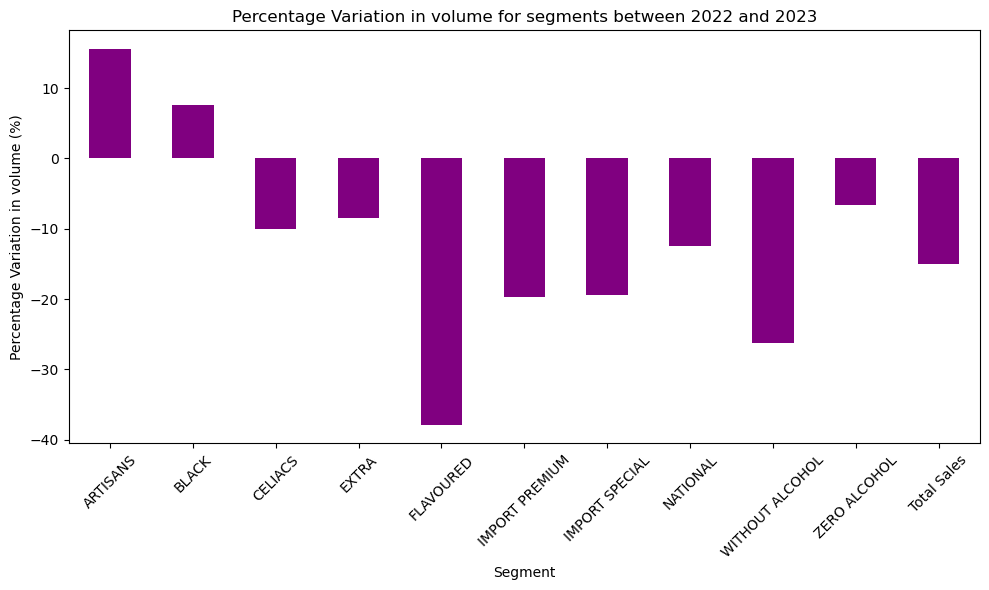

In [52]:
#Get the percentage variation between 2022 and 2023
percent_change = all_volume_predictions_for_segments[('Percentual Variation', '2023')].str.rstrip('%').astype('float')

plt.figure(figsize=(10, 6))
percent_change.plot(kind='bar', color='purple')
plt.title('Percentage Variation in volume for segments between 2022 and 2023')
plt.xlabel('Segment')
plt.ylabel('Percentage Variation in volume (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
#Now We are going to start by calculating the total sales of beer based on our manufacturers predictions

total_sales_manufacturer = all_predictions_for_manufacturers.sum(axis=0)
all_predictions_for_manufacturers.loc['Total Sales'] = total_sales_manufacturer


all_predictions_for_manufacturers

Sales in volume (Lt)                            \
Year                                2021         2022         2023   
MANUFACTURER                                                         
MANUFACTURER 1                8419261.00   8555283.00   7954621.70   
MANUFACTURER 2               31607206.00  34739090.00  24551547.45   
MANUFACTURER 3               43185111.00  48814707.00  39228301.85   
MANUFACTURER 4                4062312.00   4559751.00   4509145.93   
MANUFACTURER 5                2118599.00   2471563.00   2107964.93   
MANUFACTURER 6               29894128.00  29809775.00  24659588.45   
OTHER MANUFACTURERS           2416423.00   2603776.00   2487948.32   
Total Sales                 121703040.00 131553945.00 105499118.63   

                                  
Year                        2024  
MANUFACTURER                      
MANUFACTURER 1        8231086.43  
MANUFACTURER 2       25342922.39  
MANUFACTURER 3       44619165.79  
MANUFACTURER 4        4335648.40  
MANUFACTURER 5        2141079.22  
MANUFACTURER 6       19283240.15  
OTHER MANUFACTURERS   2484813.11  
Total Sales         106437955.49

In [54]:
#Now that we have the total sales for each year for each manufacturer, we are going to calculate the evolution in percentual terms


variation_2022 = (all_predictions_for_manufacturers[('Sales in volume (Lt)', '2022')] - all_predictions_for_manufacturers[('Sales in volume (Lt)', '2021')]) / all_predictions_for_manufacturers[('Sales in volume (Lt)', '2021')] * 100
variation_2023 = (all_predictions_for_manufacturers[('Sales in volume (Lt)', '2023')] - all_predictions_for_manufacturers[('Sales in volume (Lt)', '2022')]) / all_predictions_for_manufacturers[('Sales in volume (Lt)', '2022')] * 100
variation_2024 = (all_predictions_for_manufacturers[('Sales in volume (Lt)', '2024')] - all_predictions_for_manufacturers[('Sales in volume (Lt)', '2023')]) / all_predictions_for_manufacturers[('Sales in volume (Lt)', '2023')] * 100

#Create a new MultiIndex for the updated columns
new_columns = pd.MultiIndex.from_tuples([
    ('Sales in volume (Lt)', '2021'),
    ('Sales in volume (Lt)', '2022'),
    ('Sales in volume (Lt)', '2023'),
    ('Sales in volume (Lt)', '2024'),
    ('Percentual Variation', '2022'),
    ('Percentual Variation', '2023'),
    ('Percentual Variation', '2024')
], names=[None, 'Year'])

#Create a new DataFrame with the updated columns
all_volume_predictions_for_manufacturers = pd.DataFrame(index=all_predictions_for_manufacturers.index, columns=new_columns)

#Copy the existing data to the new DataFrame
all_volume_predictions_for_manufacturers[('Sales in volume (Lt)', '2021')] = all_predictions_for_manufacturers[('Sales in volume (Lt)', '2021')]
all_volume_predictions_for_manufacturers[('Sales in volume (Lt)', '2022')] = all_predictions_for_manufacturers[('Sales in volume (Lt)', '2022')]
all_volume_predictions_for_manufacturers[('Sales in volume (Lt)', '2023')] = all_predictions_for_manufacturers[('Sales in volume (Lt)', '2023')]
all_volume_predictions_for_manufacturers[('Sales in volume (Lt)', '2024')] = all_predictions_for_manufacturers[('Sales in volume (Lt)', '2024')]

#Add the percentual variation values to the new DataFrame
all_volume_predictions_for_manufacturers[('Percentual Variation', '2022')] = variation_2022
all_volume_predictions_for_manufacturers[('Percentual Variation', '2023')] = variation_2023
all_volume_predictions_for_manufacturers[('Percentual Variation', '2024')] = variation_2024

In [55]:
#change percentual variation columns to percentage
all_volume_predictions_for_manufacturers[('Percentual Variation', '2022')] = all_volume_predictions_for_manufacturers[('Percentual Variation', '2022')].apply(lambda x: "{:.2f}%".format(x))
all_volume_predictions_for_manufacturers[('Percentual Variation', '2023')] = all_volume_predictions_for_manufacturers[('Percentual Variation', '2023')].apply(lambda x: "{:.2f}%".format(x))
all_volume_predictions_for_manufacturers[('Percentual Variation', '2024')] = all_volume_predictions_for_manufacturers[('Percentual Variation', '2024')].apply(lambda x: "{:.2f}%".format(x))

In [56]:
all_volume_predictions_for_manufacturers

Sales in volume (Lt)                            \
Year                                2021         2022         2023   
MANUFACTURER                                                         
MANUFACTURER 1                8419261.00   8555283.00   7954621.70   
MANUFACTURER 2               31607206.00  34739090.00  24551547.45   
MANUFACTURER 3               43185111.00  48814707.00  39228301.85   
MANUFACTURER 4                4062312.00   4559751.00   4509145.93   
MANUFACTURER 5                2118599.00   2471563.00   2107964.93   
MANUFACTURER 6               29894128.00  29809775.00  24659588.45   
OTHER MANUFACTURERS           2416423.00   2603776.00   2487948.32   
Total Sales                 121703040.00 131553945.00 105499118.63   

                                 Percentual Variation                    
Year                        2024                 2022     2023     2024  
MANUFACTURER                                                             
MANUFACTURER 1        8231086.43                1.62%   -7.02%    3.48%  
MANUFACTURER 2       25342922.39                9.91%  -29.33%    3.22%  
MANUFACTURER 3       44619165.79               13.04%  -19.64%   13.74%  
MANUFACTURER 4        4335648.40               12.25%   -1.11%   -3.85%  
MANUFACTURER 5        2141079.22               16.66%  -14.71%    1.57%  
MANUFACTURER 6       19283240.15               -0.28%  -17.28%  -21.80%  
OTHER MANUFACTURERS   2484813.11                7.75%   -4.45%   -0.13%  
Total Sales         106437955.49                8.09%  -19.81%    0.89%

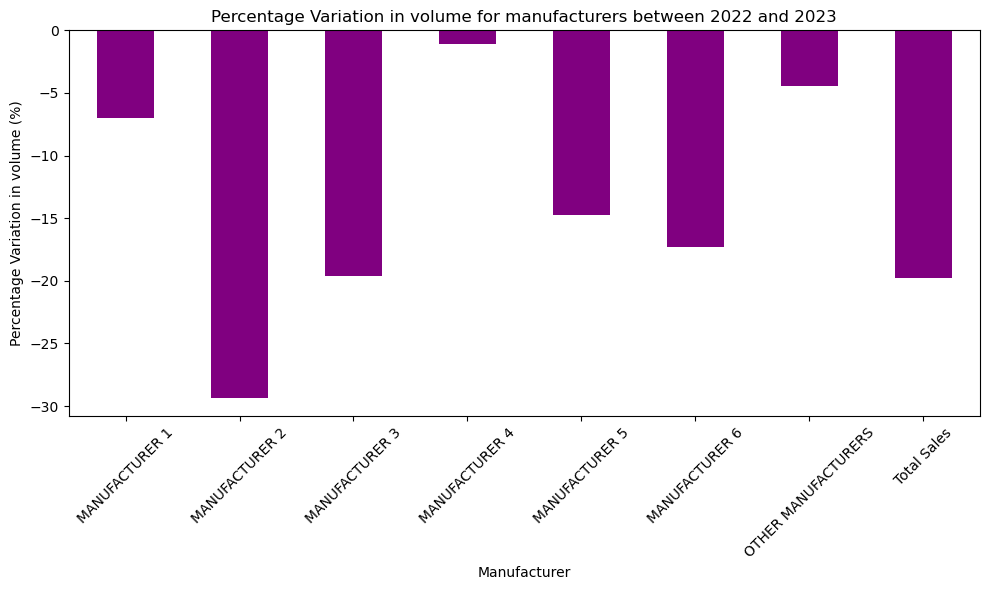

In [57]:
#Get the percentage variation between 2022 and 2023
percent_change = all_volume_predictions_for_manufacturers[('Percentual Variation', '2023')].str.rstrip('%').astype('float')

plt.figure(figsize=(10, 6))
percent_change.plot(kind='bar', color='purple')
plt.title('Percentage Variation in volume for manufacturers between 2022 and 2023')
plt.xlabel('Manufacturer')
plt.ylabel('Percentage Variation in volume (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
#Uncomment if needed as a checkpoint
# #Store all_volume_predictions_for_manufacturers and all_volume_predictions_for_segments in a csv file
# all_volume_predictions_for_manufacturers.to_csv('all_volume_predictions_for_manufacturers.csv')
# all_volume_predictions_for_segments.to_csv('all_volume_predictions_for_segments.csv')

# <span style="color: purple">**8. A final combined approach**</span> <a class="anchor" id="section_8"></a>

We have seen that there are some errors in between the total predicted sum for manufacturers and for segments. To deal with this issue, we will provide a new 'combined' forecast using the autoarima with hyperparameter tuning approach

In [59]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [60]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_combinations = ts_simple_autoarima.groupby(['Week Code', 'SEGMENT', 'MANUFACTURER'])['Sales in volume (Lt)'].sum().reset_index()

In [61]:
ts_simple_autoarima_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             6702 non-null   int64 
 1   SEGMENT               6702 non-null   object
 2   MANUFACTURER          6702 non-null   object
 3   Sales in volume (Lt)  6702 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 209.6+ KB


In [62]:
#concatenate the segment and manufacturer columns
ts_simple_autoarima_combinations['combinations'] = ts_simple_autoarima_combinations['SEGMENT'] + '_' + ts_simple_autoarima_combinations['MANUFACTURER']

In [63]:
ts_simple_autoarima_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week Code             6702 non-null   int64 
 1   SEGMENT               6702 non-null   object
 2   MANUFACTURER          6702 non-null   object
 3   Sales in volume (Lt)  6702 non-null   int64 
 4   combinations          6702 non-null   object
dtypes: int64(2), object(3)
memory usage: 261.9+ KB


In [64]:
ts_simple_autoarima_combinations.head()

Week Code   SEGMENT         MANUFACTURER  Sales in volume (Lt)  \
0          1  ARTISANS       MANUFACTURER 5                   171   
1          1  ARTISANS  OTHER MANUFACTURERS                   952   
2          1     BLACK       MANUFACTURER 1                   699   
3          1     BLACK       MANUFACTURER 2                  1569   
4          1     BLACK       MANUFACTURER 3                   794   

                   combinations  
0       ARTISANS_MANUFACTURER 5  
1  ARTISANS_OTHER MANUFACTURERS  
2          BLACK_MANUFACTURER 1  
3          BLACK_MANUFACTURER 2  
4          BLACK_MANUFACTURER 3

In [65]:
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.drop(['SEGMENT', 'MANUFACTURER'], axis=1)

Some of the segment-manufacturer already existing  combinations, and presented on the df, where not present for all weeks. For that reason, and to avoid errors, we will create a new df with all the existing combinations for all the weeks, filling with 0 the missing values.

In [66]:
#At this point, we are just checking for missing weeks in the dataset

#Create a reference DataFrame with all possible combinations and weeks
combinations = ts_simple_autoarima_combinations['combinations'].unique()
weeks = range(1, 117)  # Weeks from 1 to 116
reference_df = pd.MultiIndex.from_product([combinations, weeks], names=['combinations', 'Week Code']).to_frame(index=False)

#Merge the reference DataFrame with the original DataFrame
merged_df = pd.merge(reference_df, ts_simple_autoarima_combinations, on=['combinations', 'Week Code'], how='left')

#Check for missing values in the merged DataFrame
missing_data = merged_df[merged_df['Sales in volume (Lt)'].isnull()]
missing_combinations = missing_data['combinations'].unique()
missing_weeks = missing_data['Week Code'].unique()

print(f"Missing combinations: {missing_combinations}")
print(f"Missing weeks: {missing_weeks}")

Missing combinations: ['ARTISANS_MANUFACTURER 3' 'CELIACS_MANUFACTURER 6'
 'ARTISANS_MANUFACTURER 4' 'ARTISANS_MANUFACTURER 1']
Missing weeks: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  24  36  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88 114 115
 116  89  90  91  92  93  94  95  96  97  98]


In [67]:
#Now that we have seen, and confirmed, that there are missing weeks in the dataset, we will fill them with 0

#Create a reference DataFrame with all possible combinations and weeks
combinations = ts_simple_autoarima_combinations['combinations'].unique()
weeks = range(1, 117)  # Weeks from 1 to 116
reference_df = pd.MultiIndex.from_product([combinations, weeks], names=['combinations', 'Week Code']).to_frame(index=False)

#Merge the reference DataFrame with the original DataFrame
ts_simple_autoarima_combinations = pd.merge(reference_df, ts_simple_autoarima_combinations, on=['combinations', 'Week Code'], how='left')

#Fill missing values with 0
ts_simple_autoarima_combinations['Sales in volume (Lt)'] = ts_simple_autoarima_combinations['Sales in volume (Lt)'].fillna(0)

#Sort the DataFrame if desired
ts_simple_autoarima_combinations.sort_values(['combinations', 'Week Code'], inplace=True)

#Reset the index if needed
ts_simple_autoarima_combinations.reset_index(drop=True, inplace=True)

#Print the updated DataFrame
print(ts_simple_autoarima_combinations)

                          combinations  Week Code  Sales in volume (Lt)
0              ARTISANS_MANUFACTURER 1          1                   0.0
1              ARTISANS_MANUFACTURER 1          2                   0.0
2              ARTISANS_MANUFACTURER 1          3                   0.0
3              ARTISANS_MANUFACTURER 1          4                   0.0
4              ARTISANS_MANUFACTURER 1          5                   0.0
...                                ...        ...                   ...
6955  ZERO ALCOHOL_OTHER MANUFACTURERS        112                 160.0
6956  ZERO ALCOHOL_OTHER MANUFACTURERS        113                 148.0
6957  ZERO ALCOHOL_OTHER MANUFACTURERS        114                 123.0
6958  ZERO ALCOHOL_OTHER MANUFACTURERS        115                 267.0
6959  ZERO ALCOHOL_OTHER MANUFACTURERS        116                 204.0

[6960 rows x 3 columns]


In [68]:
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.set_index('Week Code')

In [69]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each combinations. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
combinations_models_2 = {}
combinations_data_dict_2 = {}

#We get the unique combinationss
unique_combinationss = ts_simple_autoarima_combinations['combinations'].unique()

for combinations in unique_combinationss:
    #Extract the data for the combinations we are working on
    combinations_data = ts_simple_autoarima_combinations[ts_simple_autoarima_combinations['combinations'] == combinations]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(combinations_data['Sales in volume (Lt)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    combinations_data_dict_2[combinations] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each combinations in the dictionary
    combinations_models_2[combinations] = best_model

In [70]:
#We take a look at the best models found for each segment
for combinations, best_model in combinations_models_2.items():
    print(f"Combination: {combinations}")
    print(best_model.summary())
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 2, 4)   Log Likelihood                -328.473
Date:                Thu, 06 Jul 2023   AIC                            666.947
Time:                        09:08:30   BIC                            680.357
Sample:                             0   HQIC                           672.384
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2666      0.032    -39.972      0.000      -1.329      -1.204
ma.L2          0.9001      0.060     14.986      0.000       0.782       1.018
ma.L3         -

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -753.328
Date:                Thu, 06 Jul 2023   AIC                           1512.656
Time:                        09:08:30   BIC                           1520.758
Sample:                             0   HQIC                          1515.942
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    264.6963     85.440      3.098      0.002      97.237     432.155
ar.L1          0.7688      0.054     14.198      0.000       0.663       0.875
sigma2       5.19e+04   4807.727     10.795      0.0

In [72]:
#We will apply the model to the validation set of each combinations so, as we have done in the autoarima model, we take a look at the validation set for each combinations
for combinations, data in combinations_data_dict_2.items():
    print(f"Combination: {combinations}")
    print(data['val'])
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
Week Code
111     95.0
112    124.0
113    199.0
114    227.0
115    233.0
116    259.0
Name: Sales in volume (Lt), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 3
Week Code
111    149.0
112    212.0
113    185.0
114    146.0
115    160.0
116    196.0
Name: Sales in volume (Lt), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 4
Week Code
111    20.0
112    13.0
113     4.0
114     0.0
115     0.0
116     0.0
Name: Sales in volume (Lt), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 5
Week Code
111    367.0
112    386.0
113    410.0
114    368.0
115    369.0
116    316.0
Name: Sales in volume (Lt), dtype: float64
-------------------
Combination: ARTISANS_OTHER MANUFACTURERS
Week Code
111    2268.0
112    2591.0
113    2568.0
114    2652.0
115    2513.0
116    2492.0
Name: Sales in volume (Lt), dtype: float64
-------------------
Combination: BLACK_MANUFACTURER 1
Week Code
111    708.

In [73]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each combinations and store the predictions in the dictionary.

for combinations, best_model in combinations_models_2.items():
    
    val_data = combinations_data_dict_2[combinations]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    combinations_data_dict_2[combinations]['predictions'] = predictions_df

#Print predictions of each combinations
for combinations, data in combinations_data_dict_2.items():
    print(f"Combination: {combinations}")
    print(data['predictions'])
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
           Predictions
Week Code             
111         152.209856
112         157.183364
113         168.412081
114         179.640797
115         190.869513
116         202.098229
-------------------
Combination: ARTISANS_MANUFACTURER 3
           Predictions
Week Code             
111              113.0
112              113.0
113              113.0
114              113.0
115              113.0
116              113.0
-------------------
Combination: ARTISANS_MANUFACTURER 4
           Predictions
Week Code             
111          22.831838
112          15.619234
113          11.667790
114          14.585734
115          10.432706
116           6.532853
-------------------
Combination: ARTISANS_MANUFACTURER 5
           Predictions
Week Code             
111         400.116078
112         388.394921
113         378.814333
114         370.983392
115         364.582572
116         359.350697
-------------------
Combination: ARTISANS_OTHER MANUFACT

In [74]:
# Define the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We will initialize lists to store MSE and MAPE for each combinations
mse_list_2 = []
mape_list_2 = []

#Iterate over each combinations
for combinations in combinations_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = combinations_data_dict_2[combinations]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = combinations_data_dict_2[combinations]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_2.append(mape)

    #Print the results for each combinations
    print(f"Combination: {combinations}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
MSE: 2094.2345984408876
MAPE: 27.211187787005315%
-------------------
Combination: ARTISANS_MANUFACTURER 3
MSE: 4411.333333333333
MAPE: 34.017130742251176%
-------------------
Combination: ARTISANS_MANUFACTURER 4
MSE: 72.98964349329397
MAPE: inf%
-------------------
Combination: ARTISANS_MANUFACTURER 5
MSE: 663.7755592922977
MAPE: 5.4960958522534495%
-------------------
Combination: ARTISANS_OTHER MANUFACTURERS
MSE: 15839.0
MAPE: 3.7213439470047494%
-------------------
Combination: BLACK_MANUFACTURER 1
MSE: 1039.1007234259405
MAPE: 3.865764007211556%
-------------------
Combination: BLACK_MANUFACTURER 2
MSE: 249179.08036884587
MAPE: 22.93430581793851%
-------------------
Combination: BLACK_MANUFACTURER 3
MSE: 2465.2512546471717
MAPE: 6.673879178143581%
-------------------
Combination: BLACK_MANUFACTURER 4
MSE: 3941.3333333333335
MAPE: 25.859633932642627%
-------------------
Combination: BLACK_MANUFACTURER 5
MSE: 58.435180509064715
MAPE: 132.49811385

In [92]:
#First, we get index as column called Week Code for ts_simple_autoarima_combined (containing historical data)
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.reset_index()

In [76]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_combinations['Week Code'] = ts_simple_autoarima_combinations['Week Code'].astype(str)
ts_simple_autoarima_combinations['Sales in volume (Lt)'] = ts_simple_autoarima_combinations['Sales in volume (Lt)'].astype(float)

In [87]:
# Create a new DataFrame for predictions
long_predictions_df_combinations = pd.DataFrame(columns=["Week Code", "combinations", "Predictions"])

# Iterate over each combinations and its best model
for combinations, best_model in combinations_models_2.items():
    # Get the last available week code for the combinations
    last_week_code = combinations_data_dict_2[combinations]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    combinations_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "combinations": combinations,
        "Predictions": predictions
    })

    # Append combinations predictions to the long predictions DataFrame
    long_predictions_df_combinations = long_predictions_df_combinations.append(combinations_predictions_df, ignore_index=True)

# Print the predictions for each combinations
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_combinations)

     Week Code                      combinations  Predictions
0          117           ARTISANS_MANUFACTURER 1       132.85
1          118           ARTISANS_MANUFACTURER 1       152.21
2          119           ARTISANS_MANUFACTURER 1       157.18
3          120           ARTISANS_MANUFACTURER 1       168.41
4          121           ARTISANS_MANUFACTURER 1       179.64
...        ...                               ...          ...
5575       205  ZERO ALCOHOL_OTHER MANUFACTURERS       171.00
5576       206  ZERO ALCOHOL_OTHER MANUFACTURERS       171.00
5577       207  ZERO ALCOHOL_OTHER MANUFACTURERS       171.00
5578       208  ZERO ALCOHOL_OTHER MANUFACTURERS       171.00
5579       209  ZERO ALCOHOL_OTHER MANUFACTURERS       171.00

[5580 rows x 3 columns]


In [88]:
#add a new column called source to identify the source of the data
long_predictions_df_combinations['source'] = 'Forecasts'

In [93]:
#Rename Predictions to Sales in volume (Lt), Segment to SEGMENT and Manufacturer to MANUFACTURER
long_predictions_df_combinations = long_predictions_df_combinations.rename(columns={'Predictions': 'Sales in volume (Lt)'})

In [96]:
long_predictions_df_combinations.head()

Week Code             combinations  Sales in volume (Lt)     source
0       117  ARTISANS_MANUFACTURER 1                132.85  Forecasts
1       118  ARTISANS_MANUFACTURER 1                152.21  Forecasts
2       119  ARTISANS_MANUFACTURER 1                157.18  Forecasts
3       120  ARTISANS_MANUFACTURER 1                168.41  Forecasts
4       121  ARTISANS_MANUFACTURER 1                179.64  Forecasts

In [99]:
#For ts_simple_autoarima_combined, we will add a new column called source to identify the source of the data
ts_simple_autoarima_combinations['source'] = 'Historical'


In [100]:
ts_simple_autoarima_combinations.head()

Week Code             combinations  Sales in volume (Lt)      source
0          1  ARTISANS_MANUFACTURER 1                  0.00  Historical
1          2  ARTISANS_MANUFACTURER 1                  0.00  Historical
2          3  ARTISANS_MANUFACTURER 1                  0.00  Historical
3          4  ARTISANS_MANUFACTURER 1                  0.00  Historical
4          5  ARTISANS_MANUFACTURER 1                  0.00  Historical

In [107]:
#check for nan in long_predictions_df_combinations
long_predictions_df_combinations.isnull().sum()

Week Code               0
combinations            0
Sales in volume (Lt)    0
source                  0
dtype: int64

In [108]:
#check for nan in ts_simple_autoarima_combinations
ts_simple_autoarima_combinations.isnull().sum()

Week Code               0
combinations            0
Sales in volume (Lt)    0
source                  0
dtype: int64

In [101]:
#Create a new df called all_predictions_for_volume and concatenate ts_simple_autoarima_combinations and long_predictions_df_combinations
all_predictions_for_volume = pd.concat([ts_simple_autoarima_combinations, long_predictions_df_combinations], ignore_index=True)

In [102]:
all_predictions_for_volume.head()

Week Code             combinations  Sales in volume (Lt)      source
0         1  ARTISANS_MANUFACTURER 1                  0.00  Historical
1         2  ARTISANS_MANUFACTURER 1                  0.00  Historical
2         3  ARTISANS_MANUFACTURER 1                  0.00  Historical
3         4  ARTISANS_MANUFACTURER 1                  0.00  Historical
4         5  ARTISANS_MANUFACTURER 1                  0.00  Historical

In [109]:
#Convert Week Code to int
all_predictions_for_volume['Week Code'] = all_predictions_for_volume['Week Code'].astype(int)

In [110]:
#Add a new column called Week Date to all_predictions_for_segments, using the dictionary week_dict
all_predictions_for_volume['Week Date'] = all_predictions_for_volume['Week Code'].map(week_dict)

In [111]:
#count nan
all_predictions_for_volume.isnull().sum()

Week Code               0
combinations            0
Sales in volume (Lt)    0
source                  0
Week Date               0
dtype: int64

In [112]:
all_predictions_for_volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12540 entries, 0 to 12539
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Week Code             12540 non-null  int32  
 1   combinations          12540 non-null  object 
 2   Sales in volume (Lt)  12540 non-null  float64
 3   source                12540 non-null  object 
 4   Week Date             12540 non-null  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 441.0+ KB


In [113]:
all_predictions_for_volume.head()

Week Code             combinations  Sales in volume (Lt)      source  \
0          1  ARTISANS_MANUFACTURER 1                  0.00  Historical   
1          2  ARTISANS_MANUFACTURER 1                  0.00  Historical   
2          3  ARTISANS_MANUFACTURER 1                  0.00  Historical   
3          4  ARTISANS_MANUFACTURER 1                  0.00  Historical   
4          5  ARTISANS_MANUFACTURER 1                  0.00  Historical   

    Week Date  
0  03/01/2021  
1  10/01/2021  
2  17/01/2021  
3  24/01/2021  
4  31/01/2021

In [114]:
#save the df all_predictions_for_volume to csv
all_predictions_for_volume.to_csv('data_checkpoints/all_predictions_for_volume.csv', index=False)